# **Identification**

* **Name:** Afonso Tomás de Magalhães Mateus
* **Student Number:** 202204126

* **Name:** Diogo Soares de Albergaria Oliveira
* **Student Number:** 202108325
---

# **Introduction**

Thermal inspection is an essential non-invasive technique for evaluating the condition and performance of photovoltaic (PV) modules. By analyzing infrared images, it is possible to identify anomalies such as hotspots, cracking, shading, or damaged cells, which can reduce energy efficiency and accelerate module degradation. Early detection of these issues is therefore crucial for ensuring the reliability and longevity of solar installations.

This work explores the use of artificial intelligence to automatically classify anomalies in thermal images of PV modules using the RaptorMaps Infrared Solar Modules dataset, which contains 20,000 images labeled across 12 classes. Three models are developed: a binary classifier (anomaly vs. no-anomaly), an 11-class anomaly classifier, and a full 12-class classifier including the no-anomaly category. Data augmentation techniques are applied to improve model robustness, and the proposed models are compared with established architectures such as MobileNet, VGG, EfficientNet, and ResNet. The analysis includes accuracy, F1-score, confusion matrices, and model complexity.

# **Methodoly**

## **Initial setup**

### Library Imports

In [ ]:

# Standard library
import os
import math
import json
import shutil
import subprocess
import zipfile
from pathlib import Path
from collections import Counter

# Scientific / Data
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image processing
from PIL import Image, ImageFilter

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    accuracy_score,
    classification_report
)

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, lr_scheduler
from torchvision import transforms, models

# Utils
from tqdm.auto import tqdm

### Original Dataset's Repository Cloning

In [ ]:
def setup_dataset():

    project_dir = Path.cwd()
    dataset_dir = project_dir / "InfraredSolarModules"
    final_path = dataset_dir / "InfraredSolarModules"

    if (final_path / "images").exists() and (final_path / "module_metadata.json").exists():
        return str(final_path)
    try:
        if dataset_dir.exists():
            shutil.rmtree(dataset_dir)

        subprocess.run(
            ["git", "clone", "https://github.com/RaptorMaps/InfraredSolarModules.git"],
            cwd=project_dir,
            check=True,
            capture_output=True,
            text=True
        )
    except subprocess.CalledProcessError as e:
        raise
    except FileNotFoundError:
        raise

    zip_path = dataset_dir / "2020-02-14_InfraredSolarModules.zip"
    if zip_path.exists():
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(dataset_dir)
        except Exception as e:
            raise
    else:
        raise FileNotFoundError("zip not found")

    return str(final_path)
# setup execution
try:
    dataset_path = setup_dataset()
    print("DONE.")
except Exception as e:
    raise



DONE.


##**Main Classes**

**ImagePreprocessor Class**

Since the analysed images contain low contrast and subtle intensity differences, a sharpening strategy is applied to emphasize edges and local structures that may be relevant for defect detection. In infrared imagery, many defects are expressed as small temperature gradients rather than clearly defined shapes, which makes them harder to distinguish from the background.

By applying a controlled unsharp masking filter, high-frequency components such as edges and local transitions are enhanced while the global intensity distribution of the image is preserved. This improves the visibility of thermal patterns associated with anomalies, such as hot spots or cracked cells, without introducing artificial features or modifying the underlying semantic information. As a result, the preprocessing step increases the discriminative power of the input images while keeping them faithful to the original data.

The idea of using this sharpening strategy is inspired by the approach presented in the work [1]. In this study, image enhancement techniques are shown to be effective in highlighting relevant thermal features prior to model training. Following this insight, the unsharp masking filter is adopted as a lightweight and controlled preprocessing step to improve defect visibility while preserving the physical meaning of the infrared data.


In [ ]:
class ImagePreprocessor:

    def __init__(self, radius=2, percent=150, threshold=0):
        self.radius = radius
        self.percent = percent
        self.threshold = threshold


    def apply_unsharp(self, image):
        return image.filter(
            ImageFilter.UnsharpMask(
                radius=self.radius,
                percent=self.percent,
                threshold=self.threshold
            )
        )


    def preprocess_dataframe(self, df, save_dir):

        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        processed_paths = []

        for img_path in tqdm(df["path"], desc="Preprocessing"):
            img_path = Path(img_path)
            dst = save_dir / img_path.name

            if not dst.exists():
                img = Image.open(img_path).convert("L")
                sharp = self.apply_unsharp(img)
                sharp.save(dst)

            processed_paths.append(str(dst))

        df_new = df.copy()
        df_new["sharp_path"] = processed_paths

        return df_new


**AugmentationWorker Class**

Data augmentation is handled through a dedicated component that separates online and offline augmentation, as each serves a different role in the training pipeline.


* **Offline augmentation**

    The offline augmentation strategy is inspired by the approach proposed by Ramadan et al. in [1].

    In that work, offline augmentation is used as an oversampling mechanism to mitigate the strong class imbalance present in the Infrared Solar Modules dataset, where some classes (e.g. No-Anomaly) contain several thousand samples, while others (e.g. Diode-Multi or Soiling) are represented by only a few hundred images.

    In the referenced article, offline augmentation consists mainly of horizontal and vertical flipping and brightness variation, which are applied to increase the number of samples in minority classes while preserving the physical meaning of the thermal patterns. This approach effectively balances the dataset and improves the model’s ability to learn rare defect classes.

    Following the same principle, offline augmentation in this work is also applied exclusively to the training set and never to validation or test data. In addition to flips and brightness adjustments, small rotations are introduced to account for slight changes in camera orientation during data acquisition. Even though the dataset does not explicitly contain rotated photovoltaic modules, these transformations help the model become less sensitive to a fixed image orientation, reducing overfitting to the dominant alignment present in the training data.

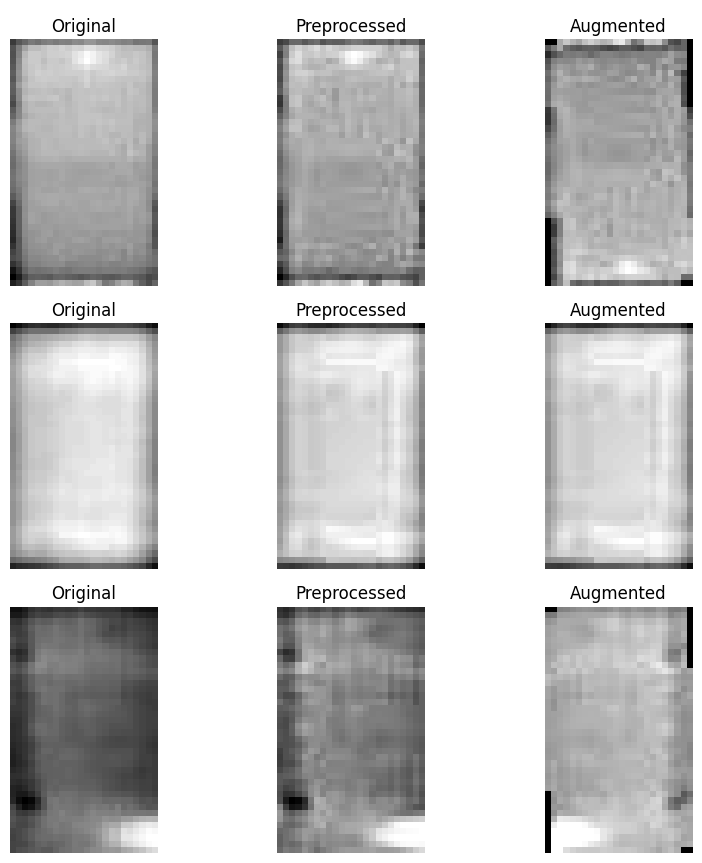
* **Online augmentation**

    Online augmentation is applied dynamically during training and serves a different purpose. While offline augmentation increases the size and balance of the dataset, online augmentation focuses on improving robustness to small, realistic variations that may occur during deployment.

    Compared to the offline strategy described in the reference article, the online augmentation used in this work is intentionally kept mild. It includes horizontal and vertical flips, slight rotations, and minor brightness and contrast changes. Because online augmentation is applied at every epoch, aggressive transformations could distort subtle thermal signatures that are critical for distinguishing between visually similar PV defects.

    For this reason, the online pipeline prioritizes realism and stability over strong perturbations. The goal is to encourage the model to focus on meaningful thermal patterns rather than memorizing exact pixel configurations, while ensuring that defect geometry and intensity relationships remain physically plausible.



In [ ]:
class AugmentationWorker:

    def __init__(self, img_size=(40, 24)):
        self.img_size = img_size

        # =========== Online ===============
        self.online_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(self.img_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.RandomRotation(5, fill=0),
            transforms.ColorJitter(brightness=0.05, contrast=0.05),
            transforms.ToTensor(),
        ])

        # =========== Val / Test ===============
        self.val_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
        ])

        self.test_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
        ])

        # =========== Offline Augmentation ===============
        self.offline_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(self.img_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.RandomRotation(5, fill=0),
            transforms.ColorJitter(brightness=0.05, contrast=0.05),
            transforms.Pad(2, padding_mode='reflect'),
        ])

        self.no_aug_transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(self.img_size),
            transforms.ToTensor(),
        ])


    # Online getters
    def get_no_aug_transform(self): return self.no_aug_transform
    def get_online_aug(self): return self.online_transform
    def get_val_transform(self): return self.val_transform
    def get_test_transform(self): return self.test_transform

    # Offline augmentation generator
    def generate_offline_aug(self, train_df, target_per_class, save_dir):

        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        aug_rows = []

        for label, group in train_df.groupby("label"):

            n_orig = len(group)
            target = target_per_class.get(label, n_orig)
            n_extra = max(0, target - n_orig)

            if n_extra == 0:
                continue

            reps = math.ceil(n_extra / n_orig)
            group_rep = pd.concat([group] * reps, ignore_index=True).iloc[:n_extra]

            for i, row in tqdm(group_rep.iterrows(), total=len(group_rep), desc=f"Offline AUG {label}", leave=False):

                try:
                    img = Image.open(row["sharp_path"]).convert("L")
                except Exception:
                    print(f"[SKIP] Corrupted image: {row['sharp_path']}")
                    continue
                aug_img = self.offline_transform(img)

                aug_pil = Image.fromarray(np.array(aug_img))

                new_name = f"{Path(row['sharp_path']).stem}_AUG_{i}.png"
                save_path = save_dir / new_name
                aug_pil.save(save_path)

                aug_rows.append({
                    "sharp_path": str(save_path),
                    "label": label
                })

        return pd.DataFrame(aug_rows)


**PyTorch Dataset Class**

The dataset is handled through a custom PyTorch Dataset that pairs each infrared image with its class label. This setup keeps data management simple and allows different transformations to be used during training and evaluation.

In [ ]:
class PVModuleDataset(Dataset):

    def __init__(self, df, label2idx, transform=None):
        self.df = df.reset_index(drop=True)
        self.label2idx = label2idx
        self.transform = transform

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['sharp_path']).convert("L")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.label2idx[row['label']], dtype=torch.long)
        return img, label

**DataSetManager Class**

Dataset handling is done through a single component that takes care of splitting and organizing the data. The dataset is divided into training, validation, and test sets using stratified sampling so that all classes keep roughly the same proportions.

Offline augmentation is applied only to the training set. Validation and test data are left unchanged so they better reflect real evaluation conditions and avoid any form of data leakage.

After each split or augmentation step, the datasets are rebuilt to keep everything consistent. This makes it easier to compare results across different models and training setups.

In [ ]:
class DataSetManager:

    def __init__(self, df, train_transform=None, val_test_transform=None):

        self.full_df = df.copy()

        self.train_df = None
        self.val_df = None
        self.test_df = None

        self.train_transform = train_transform
        self.val_test_transform = val_test_transform

        self.class_names = sorted(self.full_df["label"].unique())
        self.label2idx = {c: i for i, c in enumerate(self.class_names)}

        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None


    def split(self, train=0.8, val=0.1, test=0.1, random_state=42):

        full_df = self.full_df.copy()

        train_df, temp_df = train_test_split(
            full_df,
            test_size=(1 - train),
            stratify=full_df["label"],
            random_state=random_state
        )

        test_ratio = test / (val + test)

        val_df, test_df = train_test_split(
            temp_df,
            test_size=test_ratio,
            stratify=temp_df["label"],
            random_state=random_state
        )

        self.train_df = train_df.reset_index(drop=True)
        self.val_df = val_df.reset_index(drop=True)
        self.test_df = test_df.reset_index(drop=True)

        print(f"[INFO] Train: {len(self.train_df)} | Val: {len(self.val_df)} | Test: {len(self.test_df)}")

        self._build_datasets()


    def apply_offline_augmentation(self, aug_worker, target_per_class, save_dir):

        aug_df = aug_worker.generate_offline_aug(
            self.train_df,
            target_per_class=target_per_class,
            save_dir=save_dir
        )

        self.train_df = pd.concat([
            self.train_df[["sharp_path", "label"]],
            aug_df
        ], ignore_index=True)

        print(f"[INFO] Train size AFTER offline augmentation: {len(self.train_df)}")

        self._build_datasets()


    def _build_datasets(self):

        self.train_dataset = PVModuleDataset(
            df=self.train_df,
            label2idx=self.label2idx,
            transform=self.train_transform
        )

        self.val_dataset = PVModuleDataset(
            df=self.val_df,
            label2idx=self.label2idx,
            transform=self.val_test_transform
        )

        self.test_dataset = PVModuleDataset(
            df=self.test_df,
            label2idx=self.label2idx,
            transform=self.val_test_transform
        )

    def get_dataloaders(self, batch_size=64):
        return (
            DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True),
            DataLoader(self.val_dataset, batch_size=batch_size),
            DataLoader(self.test_dataset, batch_size=batch_size)
        )


**Some usefull functions**

In [ ]:
def compute_class_weights(train_df, label2idx, device, max_ratio=3.0):
    counts = train_df["label"].value_counts()
    total = counts.sum()
    num_classes = len(label2idx)

    weights = torch.zeros(num_classes, dtype=torch.float)

    for label, idx in label2idx.items():
        weights[idx] = total / (num_classes * counts[label])

    # limitar impacto (evita pesos absurdos)
    weights = torch.clamp(weights, max=max_ratio)

    return weights.to(device)

def load_or_create_splits(dm, base_dir, model_name):
    split_dir = Path(base_dir) / f"splits_{model_name}"
    split_dir.mkdir(parents=True, exist_ok=True)

    train_csv = split_dir / "train.csv"
    val_csv   = split_dir / "val.csv"
    test_csv  = split_dir / "test.csv"
    class_json = split_dir / "class_names.json"

    if train_csv.exists() and val_csv.exists() and test_csv.exists() and class_json.exists():
        print(f"[INFO] Loading existing splits for {model_name}")

        dm.train_df = pd.read_csv(train_csv)
        dm.val_df   = pd.read_csv(val_csv)
        dm.test_df  = pd.read_csv(test_csv)

        with open(class_json) as f:
            dm.class_names = json.load(f)

        dm.label2idx = {c: i for i, c in enumerate(dm.class_names)}
        dm._build_datasets()

    else:
        print(f"[INFO] Creating and saving splits for {model_name}")

        dm.split()  # cria splits

        dm.train_df.to_csv(train_csv, index=False)
        dm.val_df.to_csv(val_csv, index=False)
        dm.test_df.to_csv(test_csv, index=False)

        with open(class_json, "w") as f:
            json.dump(sorted(dm.class_names), f)

    return dm

def print_model_parameters(model, model_name="Model"):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"{model_name}")
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}\n")

**Our Custom CNN**

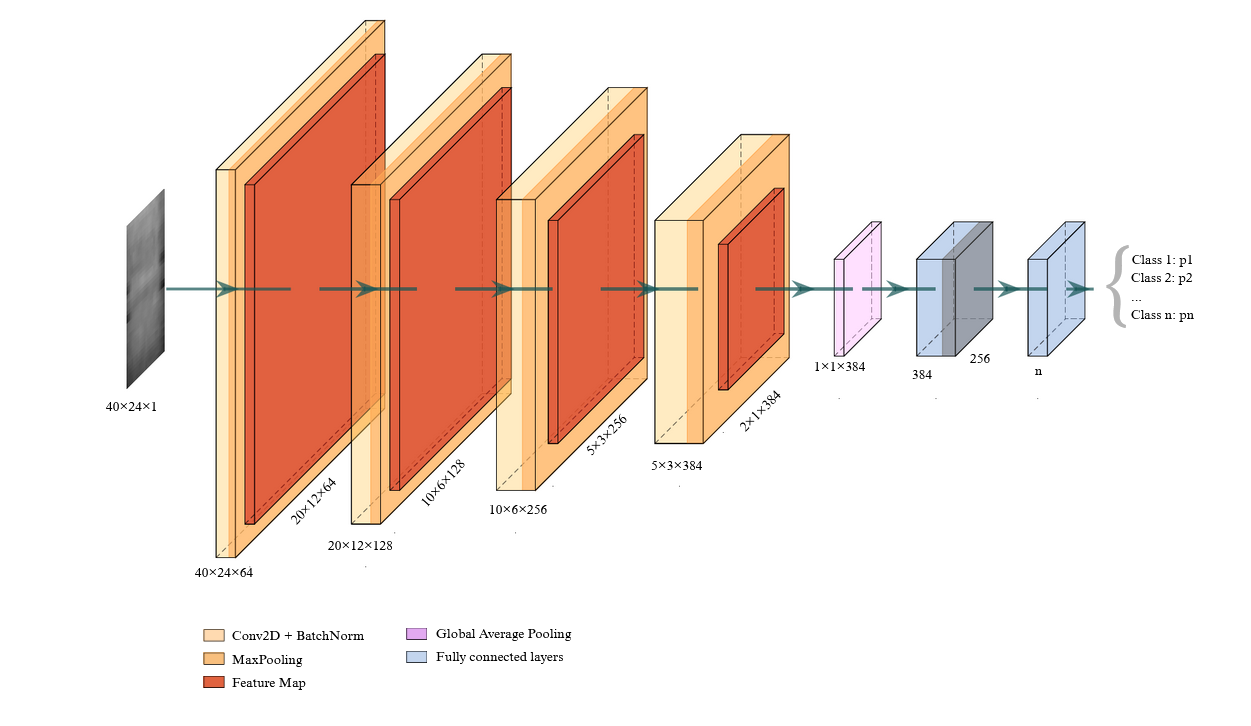

The PVClassifier is a custom convolutional neural network designed specifically for infrared photovoltaic images.
Its design is inspired by the network proposed in “Thermal inspection of photovoltaic modules with deep convolutional neural networks on edge devices in UAV” by Le et al., which demonstrated the effectiveness of CNN-based approaches for thermal fault detection in photovoltaic systems.

However, during preliminary experiments, the original architecture showed a noticeable tendency to overfit when applied to the analysed dataset. To address this, a more compact architecture was adopted, with a reduced number of parameters and the inclusion of dropout regularization. This helps limit model complexity, improves generalization, and stabilizes training without sacrificing the ability to capture relevant thermal patterns.

The network follows a classic CNN structure with multiple convolutional blocks that progressively extract low-level and high-level visual features, such as edges, local temperature transitions, and defect-related patterns. Batch normalization and max pooling contribute to training stability and spatial downsampling, while global average pooling enforces spatial invariance before classification.

Also the PVClassifier is designed to support both binary and multi-class classification through a flexible output layer and an appropriate choice of loss function. For binary classification tasks (in this case anomaly vs. no-anomaly), the network uses binary cross-entropy with logits (BCEWithLogitsLoss), which combines a sigmoid activation with the binary cross-entropy loss in a numerically stable formulation. This choice allows the model to directly output a single logit while maintaining stable gradients during training. For multi-class classification tasks, categorical cross-entropy (CrossEntropyLoss) is employed, enabling the model to learn class-specific decision boundaries across multiple defect categories. This loss function is well suited for mutually exclusive classes and aligns naturally with the softmax-based output interpretation used during inference.

By supporting both binary and multi-class classification through a flexible output layer, the PVClassifier serves as a strong baseline for comparison with deeper pretrained models. In addition, its relatively low parameter count makes it particularly suitable for edge computing scenarios, where memory, computation, and energy constraints are critical, aligning with the deployment motivations highlighted in the referenced work.

In [ ]:
class PVClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        # ---- Feature extractor ----
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(256, 384, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(384)
        self.pool4 = nn.MaxPool2d(2)

        self.gap = nn.AdaptiveAvgPool2d((1,1))

        # ---- Classifier ----
        self.fc1 = nn.Linear(384, 256)
        self.dropout = nn.Dropout(0.45)

        # num_classes logic
        if num_classes == 2:
            self.fc2 = nn.Linear(256, 1)
            self.loss_fn = nn.BCEWithLogitsLoss()
        else:
            self.fc2 = nn.Linear(256, num_classes)
            self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.gap(x)
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)


To evaluate the proposed custom model, two pretrained architectures were selected for comparison: ResNet18 and MobileNetV2. These models were chosen as they represent different design goals and are well-established in computer vision.

ResNet18 was selected as a deeper and more expressive network. Its residual connections allow it to learn complex features and make it a strong reference to test whether higher model capacity improves performance on infrared photovoltaic images.

MobileNetV2, on the other hand, was chosen for its efficiency. It is designed to use fewer parameters and less computation, making it suitable for lightweight and edge-oriented applications. This makes it a good comparison point to understand how much performance can be achieved with a more compact pretrained model.

By comparing the custom PVClassifier with ResNet18 and MobileNetV2, this work explores the trade-off between model complexity, performance, and computational cost, and aims to understand where the proposed custom model fits within this spectrum.

**ResNet18 Model Class**

The ResNet18-based model is used as a deeper pretrained architecture to evaluate the impact of transfer learning on infrared photovoltaic defect classification. It introduces residual connections that help mitigate the vanishing gradient problem and allow the network to learn more complex feature representations compared to shallow CNNs.

To adapt the model to infrared imagery, the first convolutional layer is modified to accept single-channel input instead of standard RGB images. The remaining layers benefit from pretrained weights learned on large-scale visual datasets, providing a strong initialization for feature extraction, even though the target domain differs from natural images.

ResNet18 is significantly more parameter-heavy than the custom PVClassifier, which increases its representational capacity but also raises the risk of overfitting, especially on smaller or imbalanced datasets. As a result, this architecture is primarily used as a benchmark to assess whether deeper pretrained models offer measurable advantages over lightweight custom designs in this task.

In [ ]:
class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        # Load pretrained ResNet18
        self.model = models.resnet18(pretrained=True)

        self.model.conv1 = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        nn.init.kaiming_normal_(
            self.model.conv1.weight, mode="fan_out", nonlinearity="relu"
        )

        # Classification
        if num_classes == 2:
            self.model.fc = nn.Linear(self.model.fc.in_features, 1)
            self.loss_fn = nn.BCEWithLogitsLoss()
        else:
            self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
            self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)


**MobileNet Model Class**

The MobileNetV2-based model is included as a lightweight pretrained alternative specifically designed for efficient inference. Its architecture relies on depthwise separable convolutions and inverted residual blocks, which drastically reduce the number of parameters and computational cost while maintaining competitive performance.

As with ResNet18, the first convolutional layer is adapted to process single-channel infrared images. The pretrained backbone provides a good starting point for feature extraction, while the compact design of MobileNetV2 helps control model complexity and reduce overfitting.

Compared to ResNet18, MobileNetV2 offers a better trade-off between accuracy and efficiency, making it more suitable for edge computing scenarios such as UAV-based or embedded photovoltaic inspection systems. At the same time, it remains more expressive than the custom PVClassifier, allowing a direct comparison between handcrafted lightweight architectures and optimized pretrained models.

This model therefore plays a key role in evaluating how far efficiency-oriented architectures can be pushed without compromising classification performance in infrared photovoltaic fault detection.

In [ ]:
class MobileNetV2Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        # Load pretrained MobileNetV2
        self.model = models.mobilenet_v2(pretrained=True)

        # Adapt first convolution to 1-channel IR images
        first_conv = self.model.features[0][0]
        self.model.features[0][0] = nn.Conv2d(
            1,
            first_conv.out_channels,
            kernel_size=first_conv.kernel_size,
            stride=first_conv.stride,
            padding=first_conv.padding,
            bias=False
        )
        nn.init.kaiming_normal_(
            self.model.features[0][0].weight,
            mode="fan_out",
            nonlinearity="relu"
        )

        # Classification head
        if num_classes == 2:
            self.model.classifier[1] = nn.Linear(
                self.model.classifier[1].in_features, 1
            )
            self.loss_fn = nn.BCEWithLogitsLoss()
        else:
            self.model.classifier[1] = nn.Linear(
                self.model.classifier[1].in_features, num_classes
            )
            self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)


**MetricsEngine Class:**

Model performance is evaluated using common classification metrics and visual tools. Accuracy and macro F1-score are used to measure overall performance, especially in multi-class and imbalanced settings.

Confusion matrices are used to better understand how each class is predicted, showing which defects are often confused with others. Both absolute and normalized versions help analyze overall results and per-class behavior.

Training and validation curves for loss and accuracy are also plotted to track learning over time and to identify overfitting or unstable training.

Finally, the number of model parameters is reported to relate performance with model complexity and computational cost, which is important when comparing different architectures.

In [ ]:
class MetricsEngine:

    def __init__(self, class_names):
        self.class_names = class_names

    # ===========================
    # Confusion Matrix (simple)
    # ===========================
    def compute_confusion_matrix(self, y_true, y_pred):
        return confusion_matrix(y_true, y_pred)

    def plot_confusion_matrix(self, y_true, y_pred, normalize=False, figsize=(8, 6)):
        cm = confusion_matrix(y_true, y_pred)

        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=figsize)
        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f" if normalize else "d",
            cmap="Blues",
            xticklabels=self.class_names,
            yticklabels=self.class_names
        )

        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix" + (" (Normalized)" if normalize else ""))
        plt.tight_layout()
        plt.show()

    # ===========================
    # Confusion Matrix (advanced)
    # ===========================
    def plot_confusion_matrix_advanced(self, y_true, y_pred):

        cm_abs = confusion_matrix(y_true, y_pred)
        cm_norm = confusion_matrix(y_true, y_pred, normalize="true")

        plt.figure(figsize=(12, 9))
        plt.imshow(cm_norm, interpolation="nearest", cmap="Blues", vmin=0, vmax=1)
        plt.title("Confusion Matrix (Color = Accuracy, Numbers = Absolute Counts)")
        plt.colorbar(label="Accuracy (0–1)")

        tick_marks = np.arange(len(self.class_names))
        plt.xticks(tick_marks, self.class_names, rotation=45)
        plt.yticks(tick_marks, self.class_names)

        for i in range(cm_abs.shape[0]):
            for j in range(cm_abs.shape[1]):
                value = cm_abs[i, j]
                acc = cm_norm[i, j]
                text_color = "black" if acc < 0.60 else "white"

                plt.text(
                    j, i, f"{value}",
                    ha="center",
                    va="center",
                    color=text_color,
                    fontsize=10
                )

        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        plt.tight_layout()
        plt.show()

    # ===========================
    # Metrics
    # ===========================
    def compute_f1(self, y_true, y_pred, average="macro"):
        return f1_score(y_true, y_pred, average=average)

    def compute_accuracy(self, y_true, y_pred):
        return accuracy_score(y_true, y_pred)

    def classification_report(self, y_true, y_pred):
        return classification_report(
            y_true,
            y_pred,
            target_names=self.class_names
        )

    # ===========================
    # Model Complexity
    # ===========================
    def model_complexity(self, model):
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        return {
            "total_params": total_params,
            "trainable_params": trainable_params
        }

    # ===========================
    # Training Curves
    # ===========================
    def plot_training_curves(self, history, save_dir=None):

        epochs = range(1, len(history["train_loss"]) + 1)

        # === Loss Curve ===
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, history["train_loss"], label="Train Loss")
        plt.plot(epochs, history["val_loss"], label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss Curve")
        plt.legend()

        if save_dir is not None:
            plt.savefig(f"{save_dir}/loss_curve.png")
            print(f"[SAVED] Loss curve → {save_dir}/loss_curve.png")

        plt.tight_layout()
        plt.show()

        # === Accuracy Curve ===
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, history["train_acc"], label="Train Acc")
        plt.plot(epochs, history["val_acc"], label="Val Acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy Curve")
        plt.legend()

        if save_dir is not None:
            plt.savefig(f"{save_dir}/accuracy_curve.png")
            print(f"[SAVED] Accuracy curve → {save_dir}/accuracy_curve.png")

        plt.tight_layout()
        plt.show()

        # === Save history ===
        if save_dir is not None:
            with open(f"{save_dir}/history.json", "w") as f:
                json.dump(history, f)

            print(f"[SAVED] History JSON → {save_dir}/history.json")


**ModelEngine Class**

The ModelEngine class handles the full training and testing process of the models. It acts as a wrapper around the network, managing optimization, loss computation, and performance evaluation in a consistent way across all experiments.

During training, the engine runs the training and validation loops, tracks loss and accuracy, and saves the best model based on validation performance. Early stopping is used to avoid unnecessary training once the model stops improving, helping to reduce overfitting and training time.

The testing phase is fully separated from training and is used only for final evaluation. It computes test loss and accuracy, generates predictions, and produces detailed outputs such as classification reports and confusion matrices.

By centralizing training and testing logic in a single component, this design ensures fair comparison between different models and simplifies experimentation with multiple architectures and classification settings.

In [ ]:
class ModelEngine:

    def __init__(self, model, device, optimizer, scheduler=None, class_names=None):
        self.model = model.to(device)
        self.device = device

        self.loss_fn = model.loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metrics = MetricsEngine(class_names=class_names)


    def save(self, path):
        torch.save(self.model.state_dict(), path)


    # TRAIN LOOP
    def train(self, train_loader, val_loader, num_epochs, save_path, patience=20):

        best_acc = 0.0
        best_loss = float("inf")
        best_epoch = 0
        epochs_no_improve = 0

        train_loss_hist, train_acc_hist = [], []
        val_loss_hist, val_acc_hist = [], []

        epoch_bar = tqdm(range(num_epochs), desc="Training Epochs")

        for epoch in epoch_bar:

            # TRAIN
            self.model.train()
            train_loss, train_acc = 0.0, 0.0

            batch_bar = tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}/{num_epochs}")

            for imgs, labels in batch_bar:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                self.optimizer.zero_grad()

                outputs = self.model(imgs)

                # BCE FIX
                if self.model.num_classes == 2:
                    labels_loss = labels.float().unsqueeze(1)
                else:
                    labels_loss = labels

                loss = self.loss_fn(outputs, labels_loss)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

                if self.model.num_classes == 2:
                    probs = torch.sigmoid(outputs)
                    preds = (probs >= 0.5).long().squeeze()
                    true_labels = labels.long()
                else:
                    preds = outputs.argmax(dim=1)
                    true_labels = labels

                train_acc += (preds == true_labels).sum().item() / len(true_labels)

                batch_bar.set_postfix(loss=loss.item())

            train_loss /= len(train_loader)
            train_acc  /= len(train_loader)

            # VALIDATION
            self.model.eval()
            val_loss, val_acc = 0.0, 0.0

            with torch.no_grad():
                for imgs, labels in val_loader:
                    imgs = imgs.to(self.device)
                    labels = labels.to(self.device)

                    outputs = self.model(imgs)

                    if self.model.num_classes == 2:
                        labels_loss = labels.float().unsqueeze(1)
                    else:
                        labels_loss = labels

                    loss = self.loss_fn(outputs, labels_loss)
                    val_loss += loss.item()

                    if self.model.num_classes == 2:
                        probs = torch.sigmoid(outputs)
                        preds = (probs >= 0.5).long().squeeze()
                        true_labels = labels.long()
                    else:
                        preds = outputs.argmax(dim=1)
                        true_labels = labels

                    val_acc += (preds == true_labels).sum().item() / len(true_labels)

            val_loss /= len(val_loader)
            val_acc  /= len(val_loader)

            train_loss_hist.append(train_loss)
            train_acc_hist.append(train_acc)
            val_loss_hist.append(val_loss)
            val_acc_hist.append(val_acc)

            epoch_bar.set_postfix({
                "TrainLoss": train_loss,
                "ValLoss": val_loss,
                "TrainAcc": train_acc,
                "ValAcc": val_acc
            })

            if self.scheduler:
                self.scheduler.step(val_loss)

            if val_acc > best_acc:
                best_acc = val_acc
                best_loss = val_loss
                best_epoch = epoch
                self.save(save_path)
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print("\nEarly stopping activated!")
                break

        return {
            "best_loss": best_loss,
            "best_accuracy": best_acc,
            "best_epoch": best_epoch,
            "train_loss": train_loss_hist,
            "train_acc": train_acc_hist,
            "val_loss": val_loss_hist,
            "val_acc": val_acc_hist
        }


    # TEST FUNCTION
    def test(self, dataloader, verbatim=True):

        self.model.eval()
        preds_list = []
        true_list = []

        test_loss, test_acc = 0.0, 0.0

        with torch.no_grad():
            for imgs, labels in dataloader:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(imgs)

                # correct target for BCE
                if self.model.num_classes == 2:
                    labels_loss = labels.float().unsqueeze(1)
                else:
                    labels_loss = labels

                loss = self.loss_fn(outputs, labels_loss)
                test_loss += loss.item()

                # predictions
                if self.model.num_classes == 2:
                    probs = torch.sigmoid(outputs)
                    preds = (probs >= 0.5).long().squeeze()
                    true_labels = labels.long()
                else:
                    preds = outputs.argmax(dim=1)
                    true_labels = labels

                preds_list.extend(preds.cpu().tolist())
                true_list.extend(true_labels.cpu().tolist())

                test_acc += (preds == true_labels).sum().item() / len(true_labels)

        test_loss /= len(dataloader)
        test_acc  /= len(dataloader)

        # PRINT RESULTS
        if verbatim:
            print(f"\n[TEST] Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

        # CLASSIFICATION REPORT
        report = classification_report(true_list, preds_list, target_names=self.metrics.class_names)
        if verbatim:
            print("\nClassification Report:")
            print(report)

        # ADVANCED CONFUSION MATRIX
        cm_abs = confusion_matrix(true_list, preds_list)
        cm_norm = confusion_matrix(true_list, preds_list, normalize="true")

        plt.figure(figsize=(12, 9))
        plt.imshow(cm_norm, interpolation='nearest', cmap="Blues", vmin=0, vmax=1)
        plt.title("Confusion Matrix (Color = Accuracy, Numbers = Absolute Counts)")
        plt.colorbar(label="Accuracy (0–1)")

        tick_marks = np.arange(len(self.metrics.class_names))
        plt.xticks(tick_marks, self.metrics.class_names, rotation=45)
        plt.yticks(tick_marks, self.metrics.class_names)

        # Add numbers on cells
        for i in range(cm_abs.shape[0]):
            for j in range(cm_abs.shape[1]):
                value = cm_abs[i, j]
                acc   = cm_norm[i, j]
                text_color = "black" if acc < 0.60 else "white"
                plt.text(j, i, f"{value}", ha="center", va="center",
                        color=text_color, fontsize=10)

        plt.ylabel("True label")
        plt.xlabel("Predicted label")
        plt.tight_layout()
        plt.show()

        # RETURN RESULTS
        return {
            "predictions": preds_list,
            "true_labels": true_list,
            "loss": test_loss,
            "accuracy": test_acc,
            "confusion_matrix_abs": cm_abs,
            "confusion_matrix_norm": cm_norm,
            "classification_report": report
        }


##**Setup**

**Constants Definition**

This block sets up the local environment for training and evaluation. It defines the computing device, image resolution, and all required directory paths for data, models, and results.

In [ ]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

IMG_SIZE = (40, 24)

# BASE DIRECTORIES
BASE_DIR = Path.cwd() / "PV_Project"
BASE_DIR.mkdir(parents=True, exist_ok=True)

# Dataset directory (downloaded via setup script)
DATA_DIR = Path("InfraredSolarModules/InfraredSolarModules")

# Verify dataset existence
if not (DATA_DIR / "images").exists() or not (DATA_DIR / "module_metadata.json").exists():
    raise FileNotFoundError(
        f"Dataset not found at {DATA_DIR.absolute()}!\n"
        "Please run the dataset setup script first."
    )

# DATA DIRECTORIES
PREPROCESS_DIR = BASE_DIR / "IR_preprocessed"
AUG2_DIR       = BASE_DIR / "IR_aug_2"
AUG11_DIR      = BASE_DIR / "IR_aug_11"
AUG12_DIR      = BASE_DIR / "IR_aug_12"

MODELS_DIR     = BASE_DIR / "models"
RESULTS_DIR    = BASE_DIR / "results"

# MODEL RESULT DIRECTORIES
# Custom CNN
RESULTS_BIN_CUSTOM = RESULTS_DIR / "binary_custom"
RESULTS_11_CUSTOM  = RESULTS_DIR / "11class_custom"
RESULTS_12_CUSTOM  = RESULTS_DIR / "12class_custom"

# ResNet18
RESULTS_BIN_RESNET = RESULTS_DIR / "binary_resnet18"
RESULTS_11_RESNET  = RESULTS_DIR / "11class_resnet18"
RESULTS_12_RESNET  = RESULTS_DIR / "12class_resnet18"

# MobileNetV2
RESULTS_BIN_MOBILE = RESULTS_DIR / "binary_mobilenetv2"
RESULTS_11_MOBILE  = RESULTS_DIR / "11class_mobilenetv2"
RESULTS_12_MOBILE  = RESULTS_DIR / "12class_mobilenetv2"

# MODEL WEIGHT PATHS
SAVE_BIN_CUSTOM = MODELS_DIR / "custom_binary.pth"
SAVE_11_CUSTOM  = MODELS_DIR / "custom_11class.pth"
SAVE_12_CUSTOM  = MODELS_DIR / "custom_12class.pth"

SAVE_BIN_RESNET = MODELS_DIR / "resnet18_binary.pth"
SAVE_11_RESNET  = MODELS_DIR / "resnet18_11class.pth"
SAVE_12_RESNET  = MODELS_DIR / "resnet18_12class.pth"

SAVE_BIN_MOBILE = MODELS_DIR / "mobilenetv2_binary.pth"
SAVE_11_MOBILE  = MODELS_DIR / "mobilenetv2_11class.pth"
SAVE_12_MOBILE  = MODELS_DIR / "mobilenetv2_12class.pth"

# === Binary NO-AUG ===
RESULTS_BIN_CUSTOM_NOAUG = RESULTS_DIR / "binary_custom_noaug"
SAVE_BIN_CUSTOM_NOAUG = MODELS_DIR / "custom_binary_noaug.pth"
RESULTS_BIN_CUSTOM_NOAUG.mkdir(parents=True, exist_ok=True)
# === 11-Class NO-AUG ===
RESULTS_11_CUSTOM_NOAUG = RESULTS_DIR / "11class_custom_noaug"
SAVE_11_CUSTOM_NOAUG = MODELS_DIR / "custom_11class_noaug.pth"
RESULTS_11_CUSTOM_NOAUG.mkdir(parents=True, exist_ok=True)
# === 12-Class NO-AUG ===
RESULTS_12_CUSTOM_NOAUG = RESULTS_DIR / "12class_custom_noaug"
SAVE_12_CUSTOM_NOAUG = MODELS_DIR / "custom_12class_noaug.pth"
RESULTS_12_CUSTOM_NOAUG.mkdir(parents=True, exist_ok=True)

# CREATE ALL REQUIRED DIRECTORIES
ALL_DIRS = [
    PREPROCESS_DIR, AUG2_DIR, AUG11_DIR, AUG12_DIR,
    MODELS_DIR, RESULTS_DIR,

    RESULTS_BIN_CUSTOM, RESULTS_11_CUSTOM, RESULTS_12_CUSTOM,
    RESULTS_BIN_CUSTOM_NOAUG, RESULTS_11_CUSTOM_NOAUG, RESULTS_12_CUSTOM_NOAUG,

    RESULTS_BIN_RESNET, RESULTS_11_RESNET, RESULTS_12_RESNET,
    RESULTS_BIN_MOBILE, RESULTS_11_MOBILE, RESULTS_12_MOBILE
]

for d in ALL_DIRS:
    d.mkdir(parents=True, exist_ok=True)

# LOGGING
print(f"[INFO] Base directory: {BASE_DIR.absolute()}")
print(f"[INFO] Data directory: {DATA_DIR.absolute()}")
print(f"[INFO] Models directory: {MODELS_DIR.absolute()}")
print(f"[INFO] Results directory: {RESULTS_DIR.absolute()}")
print("[INFO] Local environment ready for training and evaluation.")


Using device: cuda
[INFO] Base directory: c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project
[INFO] Data directory: c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\InfraredSolarModules\InfraredSolarModules
[INFO] Models directory: c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\models
[INFO] Results directory: c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results
[INFO] Local environment ready for training and evaluation.


**Initial configuration**

This step loads the dataset metadata, applies image preprocessing with a sharpening filter, and initializes the augmentation pipeline that will be used later during training and evaluation.

In [ ]:
# Metadata loading
meta_path = Path(DATA_DIR) / "module_metadata.json"
with open(meta_path, "r") as f:
    metadata = json.load(f)

df_raw = pd.DataFrame.from_dict(metadata, orient="index")
df_raw = df_raw.rename(columns={
    "image_filepath": "path",
    "anomaly_class": "label"
})
df_raw["path"] = df_raw["path"].apply(lambda p: str(Path(DATA_DIR) / p))

print("Loaded raw dataset:", len(df_raw))

# Preprocssing
pre = ImagePreprocessor()
df_pre = pre.preprocess_dataframe(df_raw, save_dir=PREPROCESS_DIR)

print("Preprocessing completed.")

# AugomentationWorker Ins
aug_worker = AugmentationWorker(img_size=IMG_SIZE)


Loaded raw dataset: 20000


Preprocessing:   0%|          | 0/20000 [00:00<?, ?it/s]

Preprocessing completed.


**Build Dataset for:**

For the binary classification task, all defect types are grouped into a single Anomaly class, while No-Anomaly remains unchanged. Offline augmentation is applied to the training data with a target of 18,000 images per class.

This number was chosen to give both classes enough training samples and help the model learn more stable patterns, without relying too much on synthetic data. The increase is kept below three times the original size to avoid adding too many artificial images, which could reduce the influence of real thermal information.

A second version of the dataset is also created without any augmentation. This allows a direct comparison between training with and without augmentation, making it possible to check whether augmentation actually improves performance in this binary setup. The same comparison strategy is later reused for the multi-class experiments, ensuring a consistent evaluation of the impact of data augmentation across all settings.

* Binary Models

In [ ]:
df_bin = df_pre.copy()
df_bin["label"] = df_bin["label"].apply(
    lambda x: "No-Anomaly" if x == "No-Anomaly" else "Anomaly"
)

TARGET_2 = {
    "Anomaly": 18000,
    "No-Anomaly": 18000
}

dm2 = DataSetManager(
    df=df_bin,
    train_transform=aug_worker.get_online_aug(),
    val_test_transform=aug_worker.get_val_transform()
)

dm2_noaug = DataSetManager(
    df=df_bin,
    train_transform=aug_worker.get_no_aug_transform(),
    val_test_transform=aug_worker.get_val_transform()
)

dm2 = load_or_create_splits(
    dm=dm2,
    base_dir=MODELS_DIR,
    model_name="binary"
)

dm2_noaug = load_or_create_splits(
    dm=dm2_noaug,
    base_dir=MODELS_DIR,
    model_name="binary_noaug"
)

train2_noaug, val2_noaug, test2_noaug = dm2_noaug.get_dataloaders(batch_size=64)

dm2.apply_offline_augmentation(aug_worker, TARGET_2, AUG2_DIR)

train2, val2, test2 = dm2.get_dataloaders(batch_size=64)

[INFO] Creating and saving splits for binary
[INFO] Train: 16000 | Val: 2000 | Test: 2000
[INFO] Creating and saving splits for binary_noaug
[INFO] Train: 16000 | Val: 2000 | Test: 2000


Offline AUG Anomaly:   0%|          | 0/10000 [00:00<?, ?it/s]

Offline AUG No-Anomaly:   0%|          | 0/10000 [00:00<?, ?it/s]

[INFO] Train size AFTER offline augmentation: 36000


* 11-Class Models

For the 11-class experiment, the No-Anomaly category is removed and the model is trained only on defect types. Offline augmentation is applied to the training set with specific targets, aiming to give each defect class a reasonable number of samples while avoiding excessive synthetic data.

The target values were chosen to stay within a limited growth range (again below three times the original class size). In addition, for one defect class with a considerably higher number of samples compared to the others, the dataset is slightly reduced to prevent it from dominating the learning process.

The final target values were adjusted experimentally based on the model’s behavior. For classes that the model struggles to recognize or predicts less frequently, the target size is slightly increased to provide more examples and help improve learning.

Finally, class-weighted loss is used during training to reduce bias towards more frequent defect types and encourage the model to pay more attention to rarer classes.

In [ ]:
df_11 = df_pre[df_pre["label"] != "No-Anomaly"].reset_index(drop=True)

TARGET_11 = {
    "Cell":1300, #1502
    "Cell-Multi":1500, #1030
    "Cracking":1500, #752
    "Diode":1500, #1199
    "Diode-Multi":1000, #140
    "Hot-Spot":1000, #199
    "Hot-Spot-Multi":1000, #197
    "Offline-Module":1500, #662
    "Shadowing":1500, #845
    "Soiling":1000, #163
    "Vegetation":1500, #1311
}

dm11 = DataSetManager(
    df=df_11,
    train_transform=aug_worker.get_online_aug(),
    val_test_transform=aug_worker.get_val_transform()
)

dm11_noaug = DataSetManager(
    df=df_11,
    train_transform=aug_worker.get_no_aug_transform(),
    val_test_transform=aug_worker.get_val_transform()
)

dm11 = load_or_create_splits(
    dm=dm11,
    base_dir=MODELS_DIR,
    model_name="11class"
)

dm11_noaug = load_or_create_splits(
    dm=dm11_noaug,
    base_dir=MODELS_DIR,
    model_name="11class_noaug"
)

dm11.apply_offline_augmentation(aug_worker, TARGET_11, AUG11_DIR)

train11, val11, test11 = dm11.get_dataloaders(batch_size=64)
train11_noaug, val11_noaug, test11_noaug = dm11_noaug.get_dataloaders(batch_size=64)

class_weights_11 = compute_class_weights(
    train_df=dm11.train_df,
    label2idx=dm11.label2idx,
    device=DEVICE,
    max_ratio=3.0
)

model_eleven = PVClassifier(num_classes=11)
model_eleven.loss_fn = nn.CrossEntropyLoss(weight=class_weights_11)


[INFO] Creating and saving splits for 11class
[INFO] Train: 8000 | Val: 1000 | Test: 1000
[INFO] Creating and saving splits for 11class_noaug
[INFO] Train: 8000 | Val: 1000 | Test: 1000


Offline AUG Cell-Multi:   0%|          | 0/470 [00:00<?, ?it/s]

Offline AUG Cracking:   0%|          | 0/748 [00:00<?, ?it/s]

Offline AUG Diode:   0%|          | 0/301 [00:00<?, ?it/s]

Offline AUG Diode-Multi:   0%|          | 0/860 [00:00<?, ?it/s]

Offline AUG Hot-Spot:   0%|          | 0/801 [00:00<?, ?it/s]

Offline AUG Hot-Spot-Multi:   0%|          | 0/803 [00:00<?, ?it/s]

Offline AUG Offline-Module:   0%|          | 0/838 [00:00<?, ?it/s]

Offline AUG Shadowing:   0%|          | 0/655 [00:00<?, ?it/s]

Offline AUG Soiling:   0%|          | 0/837 [00:00<?, ?it/s]

Offline AUG Vegetation:   0%|          | 0/189 [00:00<?, ?it/s]

[INFO] Train size AFTER offline augmentation: 14502


* 12-Class Models

For the 12-class experiment, all defect categories are learned together with the No-Anomaly class. Although this class already has a considerably larger number of samples than most defect classes, a small amount of offline augmentation is still applied. The increase is intentionally modest compared to other classes, as the goal is not to expand this category aggressively, but rather to preserve the model’s ability to reliably recognize it.

Preliminary experiments showed that aggressively limiting the No-Anomaly class (for example, reducing it to around 7,000 samples) led to a clear drop in performance. For this reason, a slightly higher number of samples is maintained, ensuring that the model continues to learn a strong representation of normal thermal patterns while still focusing on defect discrimination.

In [ ]:
df_12 = df_pre.copy()

TARGET_12 = {
    "Cell":2000,          #1502
    "Cell-Multi":3000,    #1030
    "Cracking":2000,      #752
    "Diode":1500,         #1199
    "Diode-Multi":500,    #140
    "Hot-Spot":1000,      #199
    "Hot-Spot-Multi":1000,#197
    "No-Anomaly":8500,    #8000
    "Offline-Module":1800,#662
    "Shadowing":2100,     #845
    "Soiling":500,        #163
    "Vegetation":1700     #1311
}

dm12 = DataSetManager(
    df=df_12,
    train_transform=aug_worker.get_online_aug(),
    val_test_transform=aug_worker.get_val_transform()
)

dm12_noaug = DataSetManager(
    df=df_12,
    train_transform=aug_worker.get_no_aug_transform(),
    val_test_transform=aug_worker.get_val_transform()
)

dm12 = load_or_create_splits(
    dm=dm12,
    base_dir=MODELS_DIR,
    model_name="12class"
)

dm12_noaug = load_or_create_splits(
    dm=dm12_noaug,
    base_dir=MODELS_DIR,
    model_name="12class_noaug"
)

dm12.apply_offline_augmentation(
    aug_worker=aug_worker,
    target_per_class=TARGET_12,
    save_dir=AUG12_DIR
)

train12, val12, test12 = dm12.get_dataloaders(batch_size=64)
train12_noaug, val12_noaug, test12_noaug = dm12_noaug.get_dataloaders(batch_size=64)

class_weights_12 = compute_class_weights(
    train_df=dm12.train_df,
    label2idx=dm12.label2idx,
    device=DEVICE,
    max_ratio=3.0
)

model_custom_12 = PVClassifier(num_classes=12)
model_custom_12.loss_fn = nn.CrossEntropyLoss(weight=class_weights_12)

[INFO] Creating and saving splits for 12class
[INFO] Train: 16000 | Val: 2000 | Test: 2000
[INFO] Creating and saving splits for 12class_noaug
[INFO] Train: 16000 | Val: 2000 | Test: 2000


Offline AUG Cell:   0%|          | 0/498 [00:00<?, ?it/s]

Offline AUG Cell-Multi:   0%|          | 0/1970 [00:00<?, ?it/s]

Offline AUG Cracking:   0%|          | 0/1248 [00:00<?, ?it/s]

Offline AUG Diode:   0%|          | 0/301 [00:00<?, ?it/s]

Offline AUG Diode-Multi:   0%|          | 0/360 [00:00<?, ?it/s]

Offline AUG Hot-Spot:   0%|          | 0/801 [00:00<?, ?it/s]

Offline AUG Hot-Spot-Multi:   0%|          | 0/803 [00:00<?, ?it/s]

Offline AUG No-Anomaly:   0%|          | 0/500 [00:00<?, ?it/s]

Offline AUG Offline-Module:   0%|          | 0/1138 [00:00<?, ?it/s]

Offline AUG Shadowing:   0%|          | 0/1255 [00:00<?, ?it/s]

Offline AUG Soiling:   0%|          | 0/337 [00:00<?, ?it/s]

Offline AUG Vegetation:   0%|          | 0/389 [00:00<?, ?it/s]

[INFO] Train size AFTER offline augmentation: 25600


##**Experiment Runner**

**Training and Evaluation Procedure**

Training and evaluation are carried out through two dedicated helper functions, responsible for managing the complete learning pipeline, from optimization to final performance assessment.

**Training Strategy**

The training function initializes the optimizer and the learning rate scheduler, executes the training and validation loops over multiple epochs, and saves the model weights corresponding to the best validation performance. In addition, training history and learning curves (loss and evaluation metrics) are stored to allow for post-training analysis and comparison between different models and configurations.

Since the learning rate has a strong impact on training stability and convergence and largely depends on the specific problem, tuning it properly can be difficult and time-consuming. Instead of spending a significant amount of time performing extensive learning rate tuning, we chose to use the Adam optimizer, as it is known to be less sensitive to the initial learning rate than standard stochastic gradient descent. This allowed us to focus on the overall model design and evaluation, while still ensuring stable and reliable training behavior.
Our choice was also influenced by the paper “Thermal inspection of photovoltaic modules with deep convolutional neural networks on edge devices in AUV” by Minhhuy Le et al. follows a similar approach, using Adam to simplify the training process and achieve consistent performance across different model configurations. Based on this work, and given the practical constraints of our project, we adopted the same optimization strategy.

To further improve training dynamics, a learning rate scheduler was employed. The scheduler progressively adjusts the learning rate during training, allowing larger updates in the early stages to accelerate convergence and smaller updates in later stages to refine the solution. This strategy helps prevent oscillations around local minima and contributes to more stable validation performance, particularly when training for a larger number of epochs.

Additionally, weight decay was applied to mitigate overfitting. By penalizing large weight values, weight decay encourages simpler models and improves generalization, which is especially important when working with relatively small datasets and high-capacity neural networks. The combination of Adam optimization, learning rate scheduling, and weight decay provides a balanced trade-off between convergence speed, stability, and generalization performance.

Finally, the choice of batch size was also an important factor during training, as it directly influences the stability and oscillation of the optimization process. In practice, the batch size controls how noisy the gradient updates are where smaller batch sizes tend to introduce higher variance, leading to noisier training curves and stronger oscillations, while larger batch sizes produce smoother and more stable updates. In this sense it almost acts like a low-pass filter in the sense that if it has an high value, the training curve will be softer but the model will take more time to learn important features (as if the time constant was higher). Through empirical experimentation, we observed this trade-off in practice and found that a batch size of 64 provided the best balance between training stability and learning efficiency. This value reduced excessive oscillations during training while still allowing the model to learn meaningful features at an adequate pace, and was therefore selected as the optimal batch size for our experiments.

**Evaluation Strategy**

The testing function reloads the saved model weights corresponding to the best validation performance and evaluates the model on the held-out test set. Final evaluation metrics, including accuracy and F1-score, are reported to provide a quantitative assessment of model performance. In addition, qualitative visual results such as confusion matrices are generated, offering deeper insight into class-wise performance and potential misclassification patterns.

This separation between training/validation and testing ensures a fair evaluation protocol and prevents information leakage from the test set into the model selection process.

In [ ]:
def train_and_validate(model,
                       train_loader,
                       val_loader,
                       class_names,
                       save_path,
                       results_dir,
                       num_epochs=40,
                       lr=1e-3,
                       weight_decay=1e-4,
                       patience=20,
                       verbatim=True):

    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience)

    engine = ModelEngine(
        model=model,
        device=DEVICE,
        optimizer=optimizer,
        scheduler=scheduler,
        class_names=class_names
    )

    if verbatim:
        print(f"\n Starting training: {model.__class__.__name__}")

    history = engine.train(
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        save_path=save_path,
        patience=patience
    )

    # Save curves + history.json
    engine.metrics.plot_training_curves(history, save_dir=results_dir)

    return history, engine


def test_model(model,
               weights_path,
               test_loader,
               class_names,
               verbatim=True):

    # Load trained weights
    model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
    model.to(DEVICE)

    # Build engine
    engine = ModelEngine(
        model=model,
        device=DEVICE,
        optimizer=None,
        scheduler=None,
        class_names=class_names
    )

    # Run test
    test_results = engine.test(test_loader, verbatim=verbatim)

    return test_results


Display result helper

In [ ]:
def add_result(
    models,
    val_acc_list,
    test_acc_list,
    val_f1_list,
    test_f1_list,
    params_list,
    name,
    history,
    engine,
    val_loader,
    test_results
):
    # Validation Accuracy (best)
    val_acc_list.append(max(history["val_acc"]) * 100)

    # Validation F1
    val_eval = engine.test(val_loader, verbatim=False)
    val_f1_list.append(
        engine.metrics.compute_f1(
            val_eval["true_labels"],
            val_eval["predictions"]
        ) * 100
    )

    # Test metrics
    test_acc_list.append(test_results["accuracy"] * 100)
    test_f1_list.append(
        engine.metrics.compute_f1(
            test_results["true_labels"],
            test_results["predictions"]
        ) * 100
    )

    # Model size (M params)
    n_params = sum(p.numel() for p in engine.model.parameters()) / 1e6
    params_list.append(n_params)

    models.append(name)


## **Binary Classification Experiments**

This helper function collects and stores the main results of each experiment, including validation and test accuracy, validation and test F1-score, and the number of model parameters.

The metrics are saved in shared lists, which are later used to generate comparative histograms across different models and configurations. The plotting itself is performed separately, keeping result collection and visualization clearly separated

In [ ]:
bin_models = []
bin_val_acc = []
bin_test_acc = []
bin_val_f1 = []
bin_test_f1 = []
bin_params = []

###Models

* **Custom**



Train






 Starting training: PVClassifier


Training Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 2/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 3/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 4/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 5/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 6/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 7/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 8/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 9/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 10/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 11/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 12/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 13/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 14/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 15/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 16/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 17/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 18/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 19/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 20/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 21/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 22/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 23/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 24/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 25/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 26/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 27/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 28/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 29/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 30/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 31/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 32/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 33/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 34/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 35/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 36/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 37/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 38/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 39/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 40/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 41/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 42/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 43/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 44/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 45/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 46/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 47/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 48/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 49/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 50/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 51/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 52/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 53/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 54/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 55/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 56/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 57/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 58/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 59/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 60/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 61/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 62/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 63/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 64/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 65/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 66/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 67/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 68/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 69/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 70/200:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 71/200:   0%|          | 0/563 [00:00<?, ?it/s]


Early stopping activated!
[SAVED] Loss curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\binary_custom/loss_curve.png


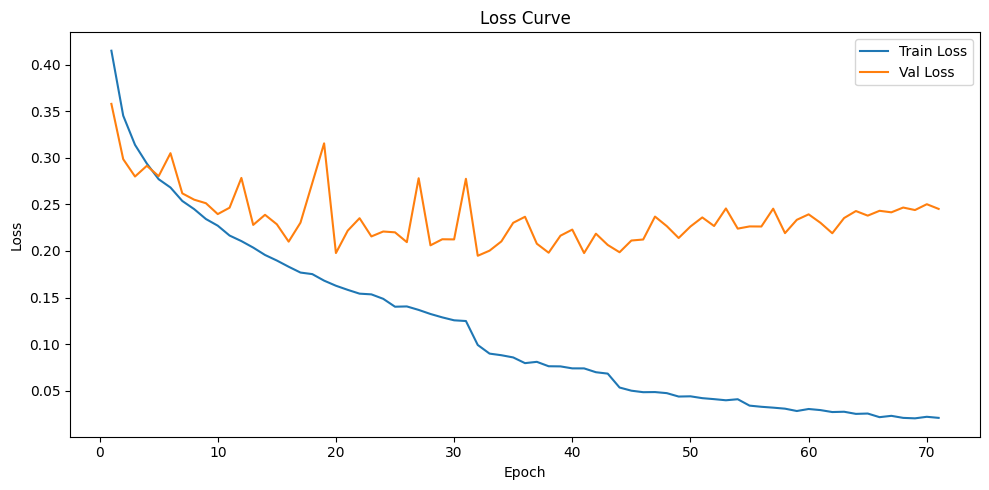

[SAVED] Accuracy curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\binary_custom/accuracy_curve.png


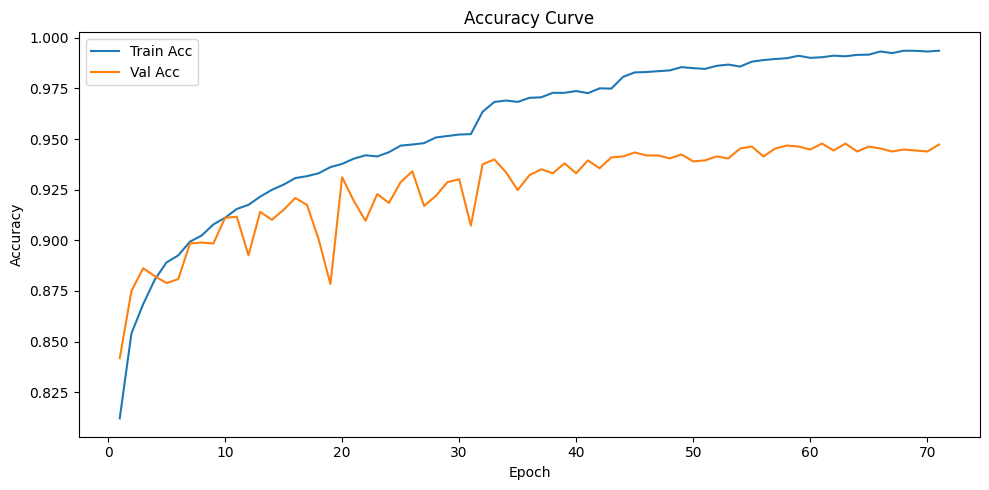

[SAVED] History JSON → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\binary_custom/history.json


In [ ]:
model_bin_custom = PVClassifier(num_classes=2)

history_bin, engine_bin = train_and_validate(
    model=model_bin_custom,
    train_loader=train2,
    val_loader=val2,
    class_names=["Anomaly", "No-Anomaly"],
    save_path=SAVE_BIN_CUSTOM,
    results_dir=RESULTS_BIN_CUSTOM,
    num_epochs=200,
    lr=3e-4,
    weight_decay=1e-4,
    patience=10
)

Test

C:\Users\Afonso Mateus\AppData\Local\Temp\ipykernel_17820\1149860589.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_


[TEST] Loss: 0.1699, Accuracy: 0.9551

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.96      0.95      0.96      1000
  No-Anomaly       0.95      0.96      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



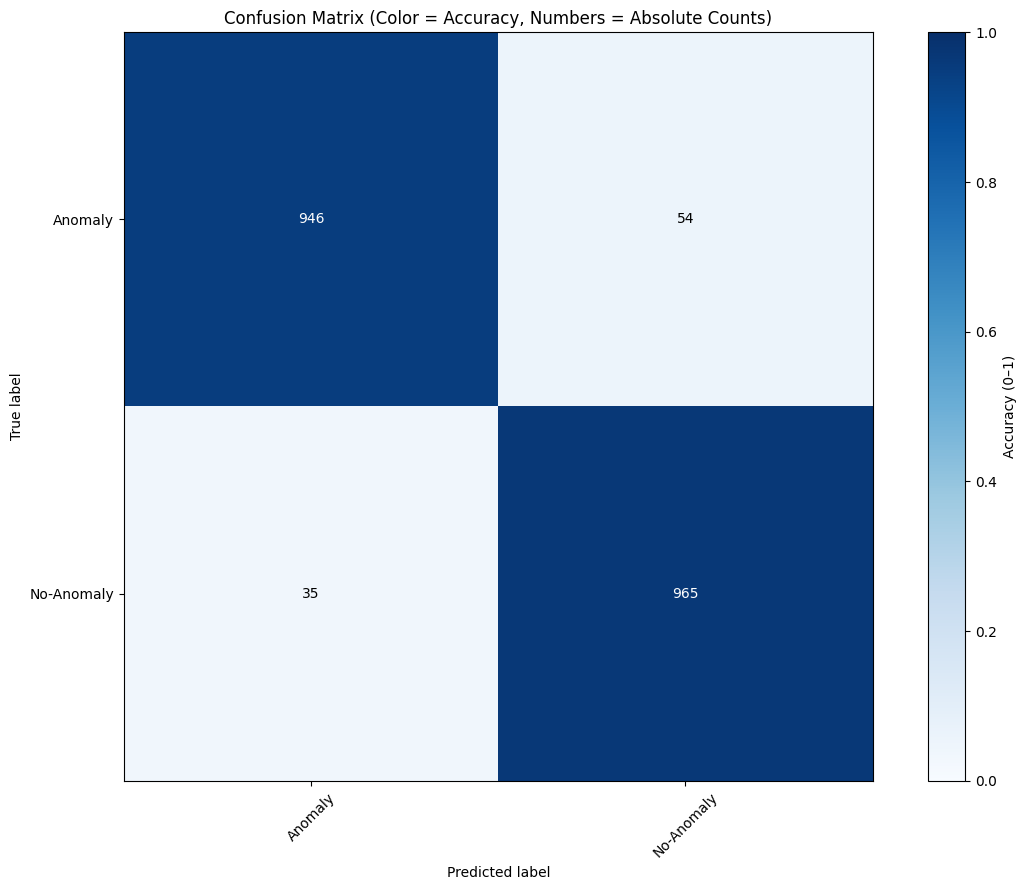

In [ ]:
results_bin = test_model(
    model=model_bin_custom,
    weights_path=SAVE_BIN_CUSTOM,
    test_loader=test2,
    class_names=["Anomaly", "No-Anomaly"]
)

In [ ]:
print_model_parameters(model_bin_custom, "Custom CNN (Binary)")

Custom CNN (Binary)
  Total parameters: 1,355,265
  Trainable parameters: 1,355,265



In [ ]:
add_result(
    bin_models,
    bin_val_acc,
    bin_test_acc,
    bin_val_f1,
    bin_test_f1,
    bin_params,
    "Custom (Aug)",
    history_bin,
    engine_bin,
    val2,
    results_bin
)


Custom Without Agumentation


 Starting training: PVClassifier


Training Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 16/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 18/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 20/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 21/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 22/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 23/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 24/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 25/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 26/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 27/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 28/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 29/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 30/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 31/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 32/200:   0%|          | 0/250 [00:00<?, ?it/s]


Early stopping activated!
[SAVED] Loss curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\binary_custom_noaug/loss_curve.png


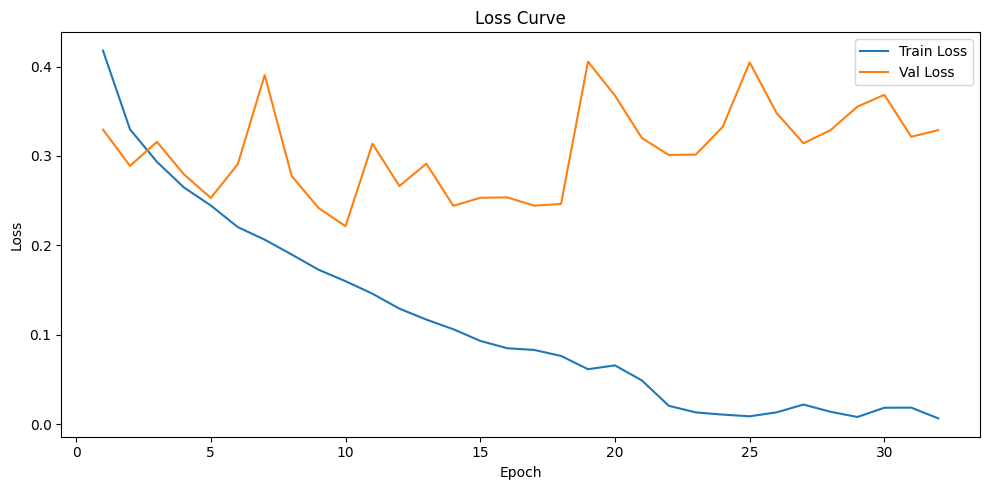

[SAVED] Accuracy curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\binary_custom_noaug/accuracy_curve.png


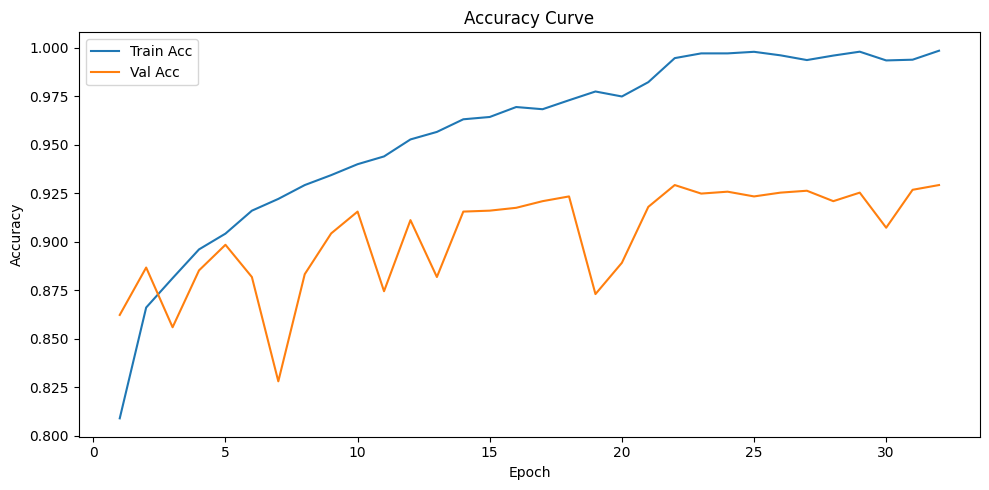

[SAVED] History JSON → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\binary_custom_noaug/history.json


In [ ]:
model_bin_custom_noaug = PVClassifier(num_classes=2)

history_bin_noaug, engine_bin_noaug = train_and_validate(
    model=model_bin_custom_noaug,
    train_loader=train2_noaug,
    val_loader=val2_noaug,
    class_names=["Anomaly", "No-Anomaly"],
    save_path=SAVE_BIN_CUSTOM_NOAUG,
    results_dir=RESULTS_BIN_CUSTOM_NOAUG,
    num_epochs=200,
    lr=3e-4,
    weight_decay=1e-4,
    patience=10
)


C:\Users\Afonso Mateus\AppData\Local\Temp\ipykernel_17820\1149860589.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_


[TEST] Loss: 0.2751, Accuracy: 0.9326

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.97      0.89      0.93      1000
  No-Anomaly       0.90      0.97      0.94      1000

    accuracy                           0.93      2000
   macro avg       0.94      0.93      0.93      2000
weighted avg       0.94      0.93      0.93      2000



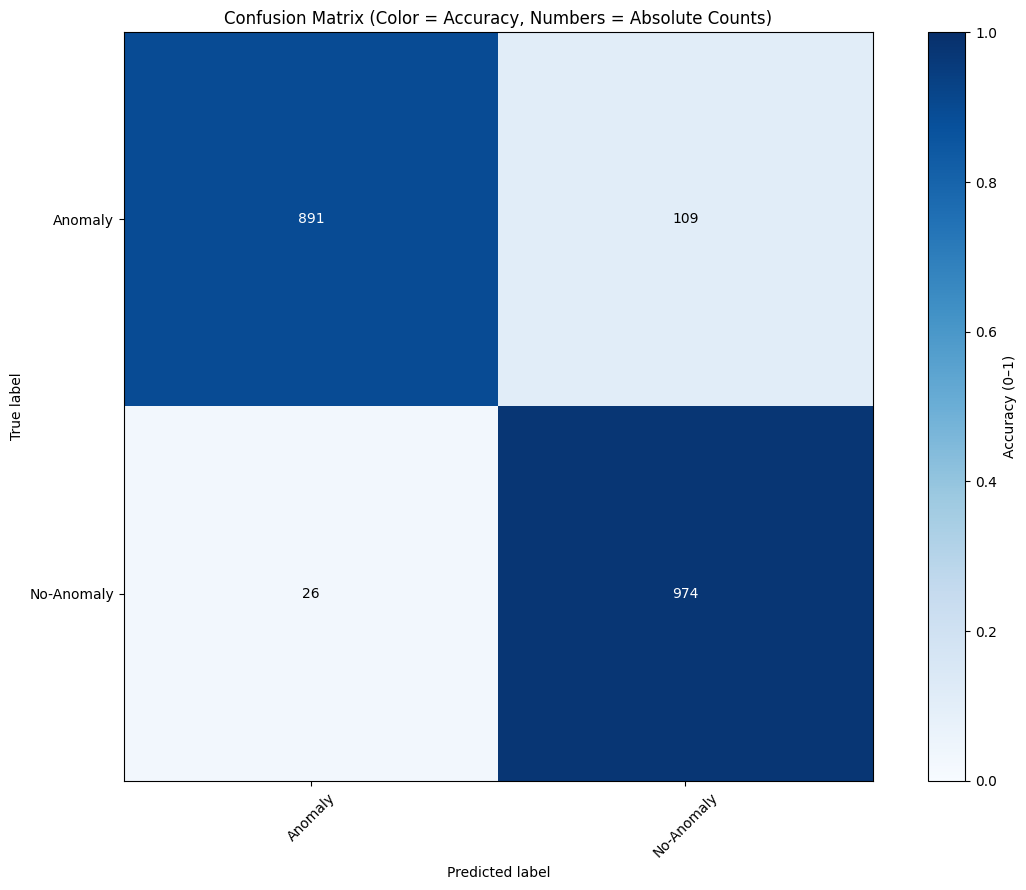

In [ ]:
results_bin_noaug = test_model(
    model=model_bin_custom_noaug,
    weights_path=SAVE_BIN_CUSTOM_NOAUG,
    test_loader=test2_noaug,
    class_names=["Anomaly", "No-Anomaly"]
)

In [ ]:
print_model_parameters(model_bin_custom_noaug, "Custom CNN without Aug(Binary)")

Custom CNN without Aug(Binary)
  Total parameters: 1,355,265
  Trainable parameters: 1,355,265



In [ ]:
add_result(
    bin_models,
    bin_val_acc,
    bin_test_acc,
    bin_val_f1,
    bin_test_f1,
    bin_params,
    "Custom (No Aug)",
    history_bin_noaug,
    engine_bin_noaug,
    val2_noaug,
    results_bin_noaug
)

* **ResNet18**

c:\Users\Afonso Mateus\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Afonso Mateus\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 Starting training: ResNet18Classifier


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/563 [00:00<?, ?it/s]


Early stopping activated!
[SAVED] Loss curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\binary_resnet18/loss_curve.png


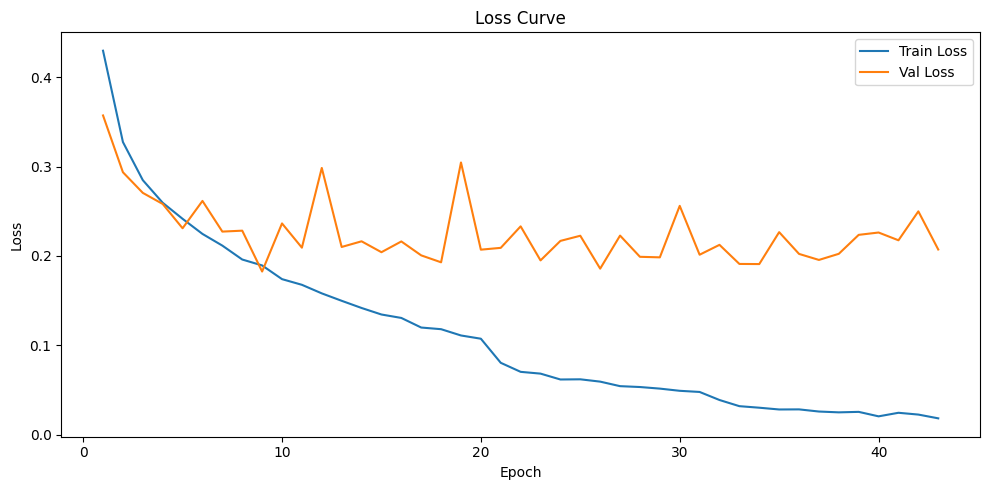

[SAVED] Accuracy curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\binary_resnet18/accuracy_curve.png


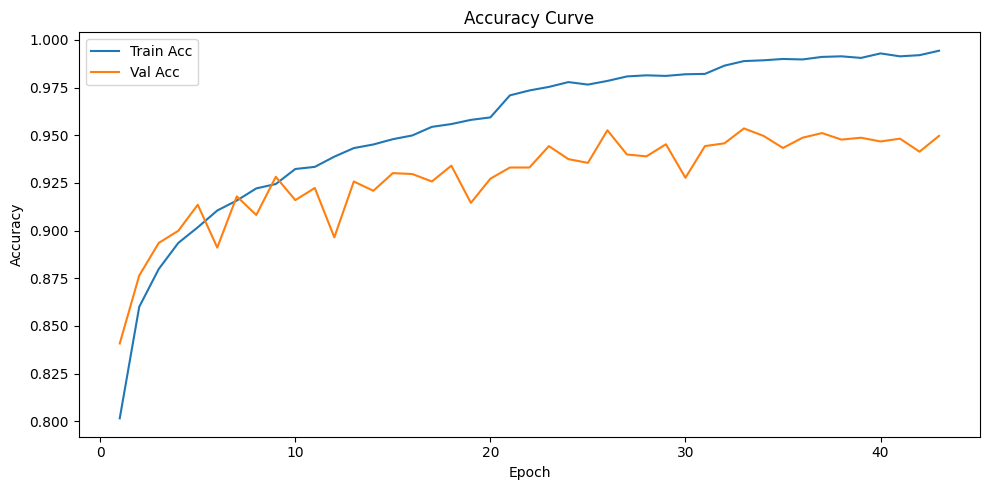

[SAVED] History JSON → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\binary_resnet18/history.json


In [ ]:
model_resnet_bin = ResNet18Classifier(num_classes=2)

history_resnet_bin, engine_resnet_bin = train_and_validate(
    model=model_resnet_bin,
    train_loader=train2,
    val_loader=val2,
    class_names=["Anomaly", "No-Anomaly"],
    save_path=SAVE_BIN_RESNET,
    results_dir=RESULTS_BIN_RESNET,
    num_epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=10
)

C:\Users\Afonso Mateus\AppData\Local\Temp\ipykernel_17820\1149860589.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_


[TEST] Loss: 0.1743, Accuracy: 0.9502

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.96      0.94      0.95      1000
  No-Anomaly       0.94      0.96      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



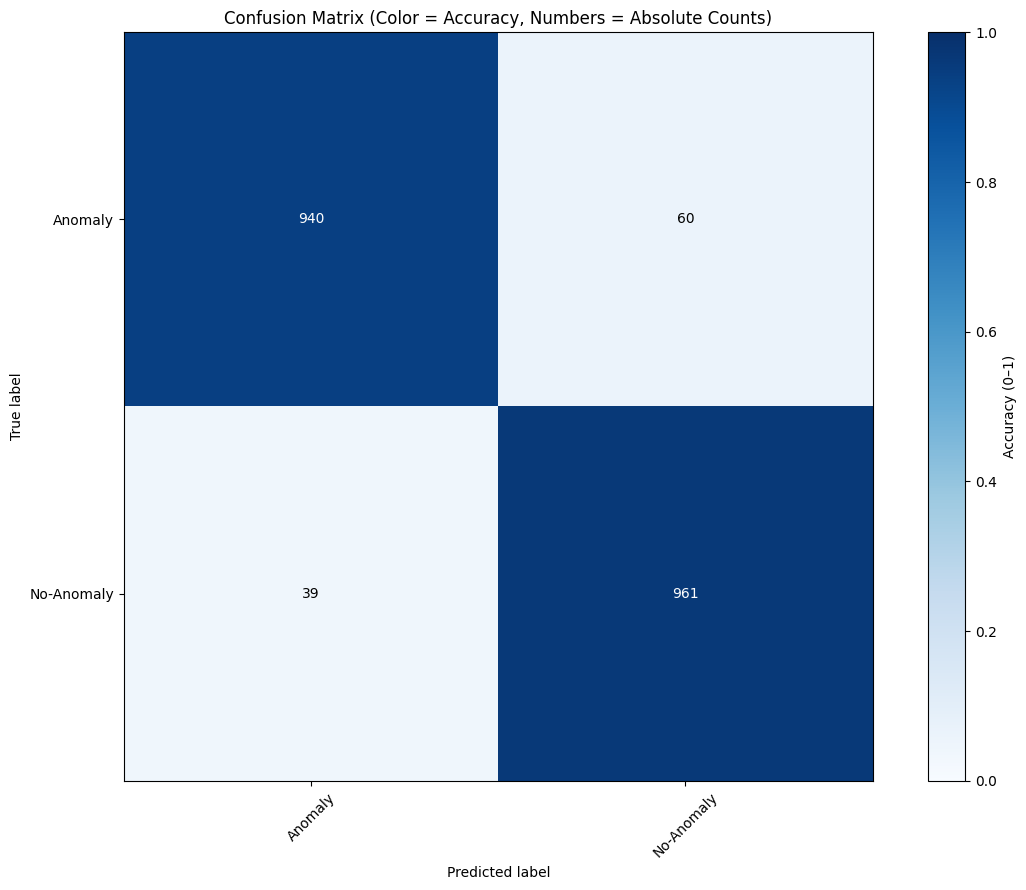

In [ ]:
results_resnet_bin = test_model(
    model=model_resnet_bin,
    weights_path=SAVE_BIN_RESNET,
    test_loader=test2,
    class_names=["Anomaly", "No-Anomaly"]
)

In [ ]:
print_model_parameters(model_resnet_bin, "ResNet(Binary)")

ResNet(Binary)
  Total parameters: 11,170,753
  Trainable parameters: 11,170,753



In [ ]:
add_result(
    bin_models,
    bin_val_acc,
    bin_test_acc,
    bin_val_f1,
    bin_test_f1,
    bin_params,
    "ResNet18",
    history_resnet_bin,
    engine_resnet_bin,
    val2,
    results_resnet_bin
)


 * **MobileNetV2**

c:\Users\Afonso Mateus\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Afonso Mateus\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 Starting training: MobileNetV2Classifier


Training Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 2/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 3/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 4/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 5/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 6/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 7/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 8/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 9/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 10/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 11/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 12/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 13/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 14/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 15/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 16/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 17/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 18/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 19/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 20/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 21/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 22/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 23/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 24/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 25/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 26/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 27/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 28/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 29/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 30/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 31/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 32/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 33/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 34/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 35/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 36/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 37/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 38/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 39/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 40/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 41/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 42/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 43/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 44/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 45/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 46/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 47/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 48/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 49/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 50/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 51/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 52/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 53/100:   0%|          | 0/563 [00:00<?, ?it/s]

Epoch 54/100:   0%|          | 0/563 [00:00<?, ?it/s]


Early stopping activated!
[SAVED] Loss curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\binary_mobilenetv2/loss_curve.png


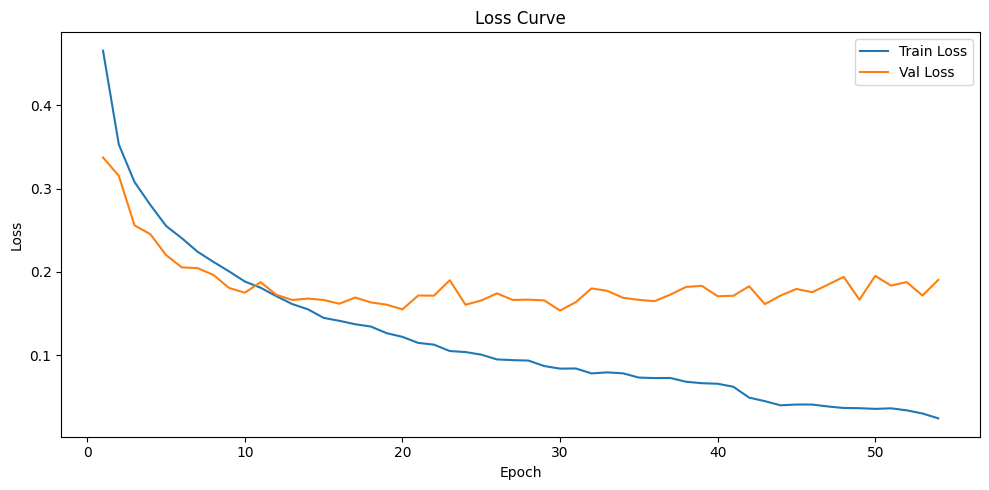

[SAVED] Accuracy curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\binary_mobilenetv2/accuracy_curve.png


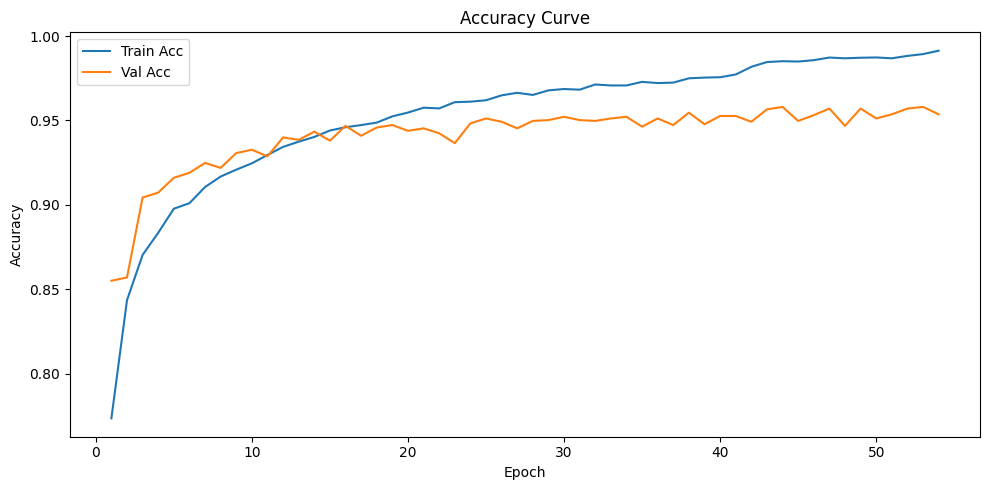

[SAVED] History JSON → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\binary_mobilenetv2/history.json


In [ ]:
model_mobile_bin = MobileNetV2Classifier(num_classes=2)

history_mobile_bin, engine_mobile_bin = train_and_validate(
    model=model_mobile_bin,
    train_loader=train2,
    val_loader=val2,
    class_names=["Anomaly", "No-Anomaly"],
    save_path=SAVE_BIN_MOBILE,
    results_dir=RESULTS_BIN_MOBILE,
    num_epochs=100,
    lr=1e-4,
    weight_decay=1e-4,
    patience=10
)

C:\Users\Afonso Mateus\AppData\Local\Temp\ipykernel_17820\1149860589.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_


[TEST] Loss: 0.1774, Accuracy: 0.9429

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.95      0.93      0.94      1000
  No-Anomaly       0.93      0.96      0.95      1000

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



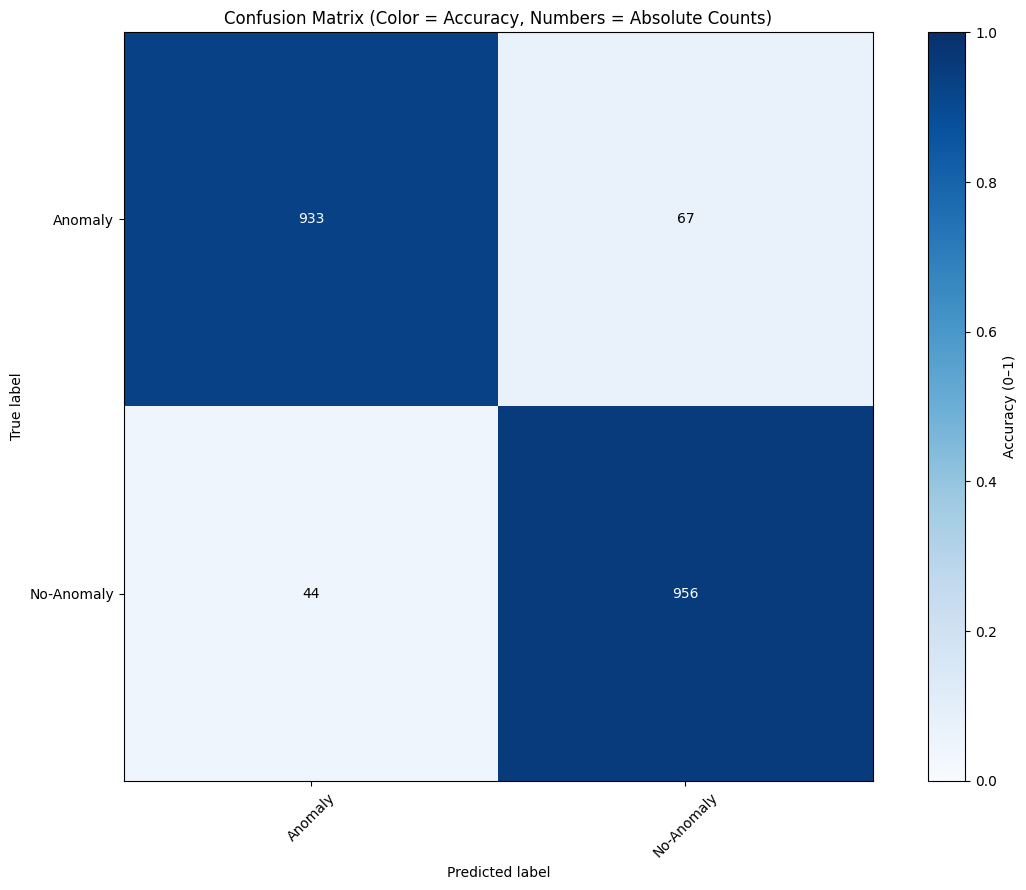

In [ ]:
results_mobile_bin = test_model(
    model=model_mobile_bin,
    weights_path=SAVE_BIN_MOBILE,
    test_loader=test2,
    class_names=["Anomaly", "No-Anomaly"]
)

In [ ]:
print_model_parameters(model_mobile_bin, "MobileNet(Binary)")

MobileNet(Binary)
  Total parameters: 2,224,577
  Trainable parameters: 2,224,577



In [ ]:
add_result(
    bin_models,
    bin_val_acc,
    bin_test_acc,
    bin_val_f1,
    bin_test_f1,
    bin_params,
    "MobileNetV2",
    history_mobile_bin,
    engine_mobile_bin,
    val2,
    results_mobile_bin
)


### **Results**

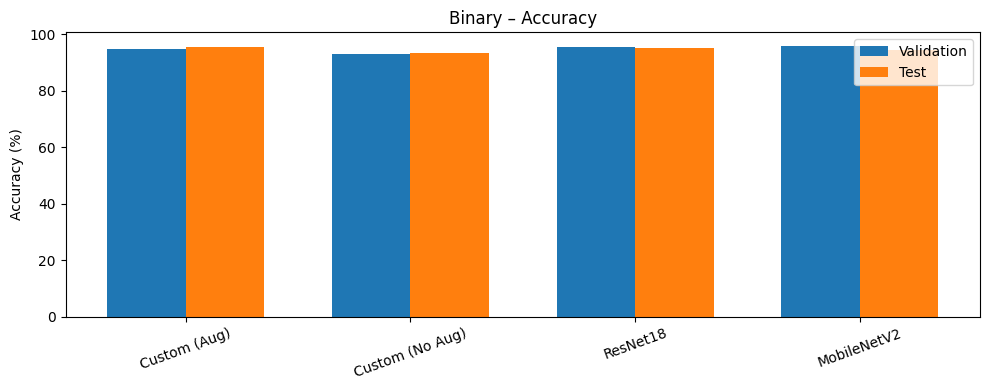

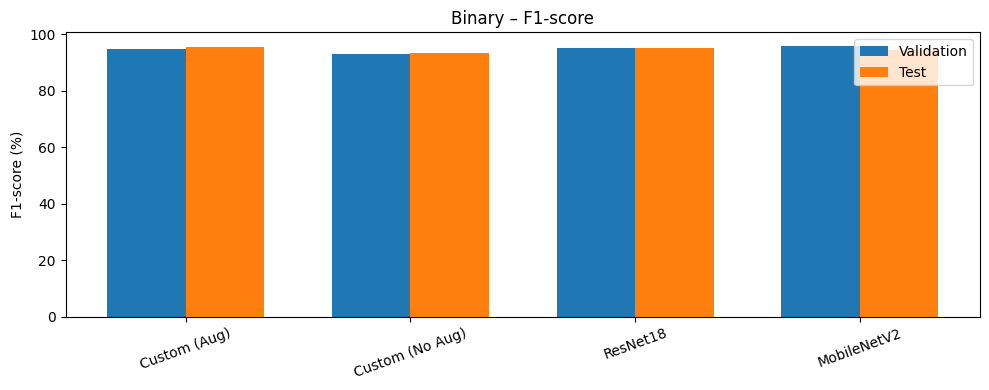

In [ ]:
x = np.arange(len(bin_models))
w = 0.35

plt.figure(figsize=(10,4))
plt.bar(x - w/2, bin_val_acc, w, label="Validation")
plt.bar(x + w/2, bin_test_acc, w, label="Test")
plt.xticks(x, bin_models, rotation=20)
plt.ylabel("Accuracy (%)")
plt.title("Binary – Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.bar(x - w/2, bin_val_f1, w, label="Validation")
plt.bar(x + w/2, bin_test_f1, w, label="Test")
plt.xticks(x, bin_models, rotation=20)
plt.ylabel("F1-score (%)")
plt.title("Binary – F1-score")
plt.legend()
plt.tight_layout()
plt.show()

| Model               | Accuracy (%) | F1-Score (%) | # Parameters |
|---------------------|--------------|--------------|--------------|
| Custom w/ Aug       | 95.5         | 96.0         | 1,355,265    |
| Custom without Aug  | 93.26        | 93.0         | 1,355,265    |
| ResNet18            | 95.02        | 95.0         | 11,170,753   |
| MobileNetV2         | 94.29        | 94.0         | 2,224,577    |

The previous Table summarizes the performance of the evaluated models in terms of accuracy, F1-score, and number of parameters, enabling a direct comparison between different architectures and training strategies.

Overall, the results show that the models achieve very similar performance, with consistently high accuracy and F1-score values, indicating that the classification task is effectively addressed by all the evaluated approaches.

The comparison between the Custom model with data augmentation and the Custom model without data augmentation reveals that the use of augmentation techniques leads to an improvement of approximately 2% in both accuracy and F1-score. This relatively small gain suggests that the original dataset already contains a sufficient number of images to allow for effective training and that the classes were reasonably well balanced even without augmentation, wich is an expected outcome given the initial class distribution. Nevertheless, the observed improvement confirms that data augmentation contributes positively to the model’s generalization ability, helping to mitigate overfitting and increasing robustness to small variations in the input data. This can be seen in the training and validation curves of both where the "without aug" version has a bigger overfiting.

Regarding the comparison between the different architectures (Custom, ResNet18, and MobileNetV2), the results indicate that the Custom model achieves the best overall performance, despite having a significantly lower number of parameters. This finding suggests that, for this specific classification task, a simpler architecture is sufficient to capture the most relevant discriminative features. This behavior is consistent with the fact that the input images have a low spatial resolution, which reduces the need for deep and highly parameterized networks such as ResNet18 or MobileNetV2, originally designed for more complex, high-resolution images.

Furthermore, the strong performance of the Custom model highlights the effectiveness of tailoring the architecture to the problem domain, achieving an efficient balance between representational capacity and computational complexity. These results reinforce the notion that increasing model complexity does not necessarily translate into improved performance, particularly when the characteristics of the data do not justify a large number of parameters.

**Conclusion**:
Binary anomaly detection is a relatively well-posed problem where lightweight models already achieve very high performance, and data augmentation provides a clear benefit by improving robustness and reducing overfitting.

## **11-Class Experiments**

In [ ]:
cls11_models = []
cls11_val_acc = []
cls11_test_acc = []
cls11_val_f1 = []
cls11_test_f1 = []
cls11_params = []

###Models

* **Custom**


 Starting training: PVClassifier


Training Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 2/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 3/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 4/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 5/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 6/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 7/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 8/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 9/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 10/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 11/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 12/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 13/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 14/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 15/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 16/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 17/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 18/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 19/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 20/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 21/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 22/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 23/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 24/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 25/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 26/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 27/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 28/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 29/200:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 30/200:   0%|          | 0/227 [00:00<?, ?it/s]


Early stopping activated!
[SAVED] Loss curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\11class_custom/loss_curve.png


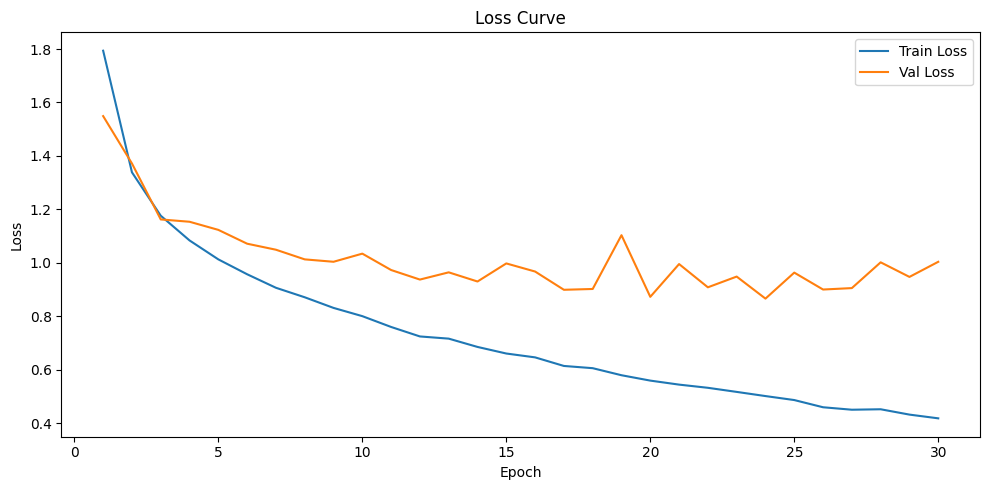

[SAVED] Accuracy curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\11class_custom/accuracy_curve.png


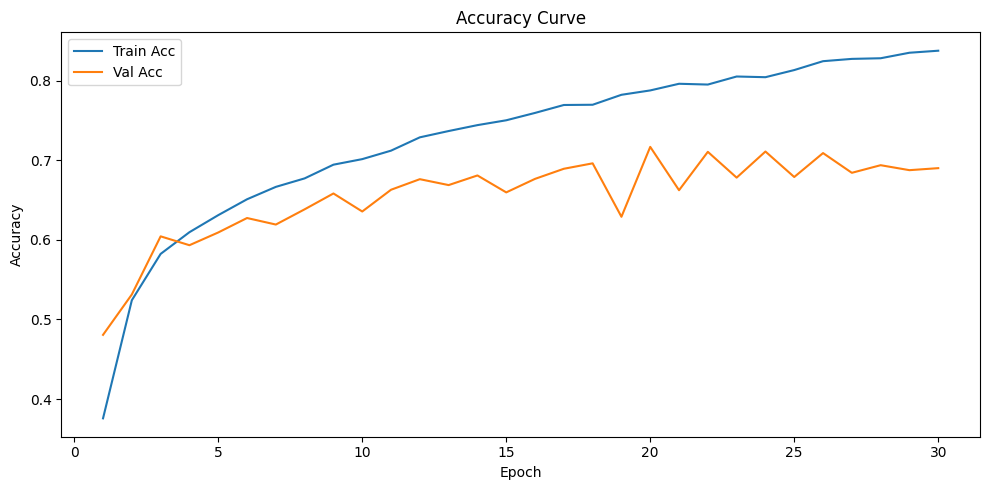

[SAVED] History JSON → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\11class_custom/history.json


In [ ]:

history_11, engine_11 = train_and_validate(
    model=model_eleven,
    train_loader=train11,
    val_loader=val11,
    class_names=sorted(dm11.class_names),
    save_path=SAVE_11_CUSTOM,
    results_dir=RESULTS_11_CUSTOM,
    num_epochs=200,
    lr=3e-4,
    weight_decay=1e-4,
    patience=10
)

Test

C:\Users\Afonso Mateus\AppData\Local\Temp\ipykernel_17820\1149860589.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_


[TEST] Loss: 0.8703, Accuracy: 0.7158

Classification Report:
                precision    recall  f1-score   support

          Cell       0.61      0.73      0.66       187
    Cell-Multi       0.59      0.36      0.45       129
      Cracking       0.70      0.62      0.66        94
         Diode       0.97      0.93      0.95       150
   Diode-Multi       0.89      0.94      0.91        17
      Hot-Spot       0.78      0.56      0.65        25
Hot-Spot-Multi       0.67      0.56      0.61        25
Offline-Module       0.65      0.95      0.77        83
     Shadowing       0.75      0.81      0.78       106
       Soiling       0.29      0.40      0.33        20
    Vegetation       0.77      0.70      0.73       164

      accuracy                           0.71      1000
     macro avg       0.70      0.69      0.68      1000
  weighted avg       0.72      0.71      0.71      1000



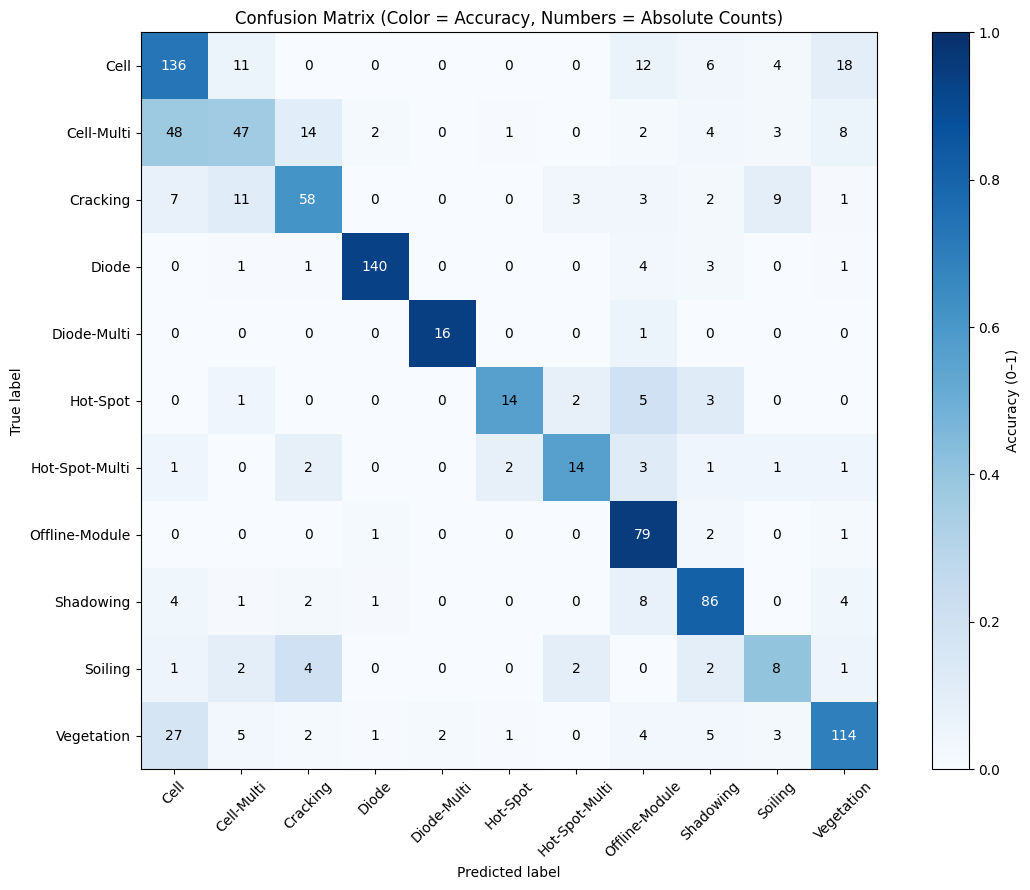

In [ ]:
class_names_11 = sorted(dm11.class_names)

results_11 = test_model(
    model=model_eleven,
    weights_path=SAVE_11_CUSTOM,
    test_loader=test11,
    class_names=class_names_11
)


In [ ]:
print_model_parameters(model_eleven, "Custom (11)")

Custom (11)
  Total parameters: 1,357,835
  Trainable parameters: 1,357,835



In [ ]:
add_result(
    cls11_models,
    cls11_val_acc,
    cls11_test_acc,
    cls11_val_f1,
    cls11_test_f1,
    cls11_params,
    "Custom (Aug)",
    history_11,
    engine_11,
    val11,
    results_11
)

* **Custom without Augmentation**


 Starting training: PVClassifier


Training Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 6/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 7/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 9/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 11/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 12/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 13/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 14/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 15/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 16/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 17/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 18/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 19/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 20/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 21/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 22/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 23/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 24/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 25/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 26/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 27/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 28/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 29/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 30/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 31/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 32/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 33/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 34/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 35/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 36/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 37/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 38/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 39/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 40/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 41/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 42/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 43/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 44/200:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 45/200:   0%|          | 0/125 [00:00<?, ?it/s]


Early stopping activated!
[SAVED] Loss curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\11class_custom_noaug/loss_curve.png


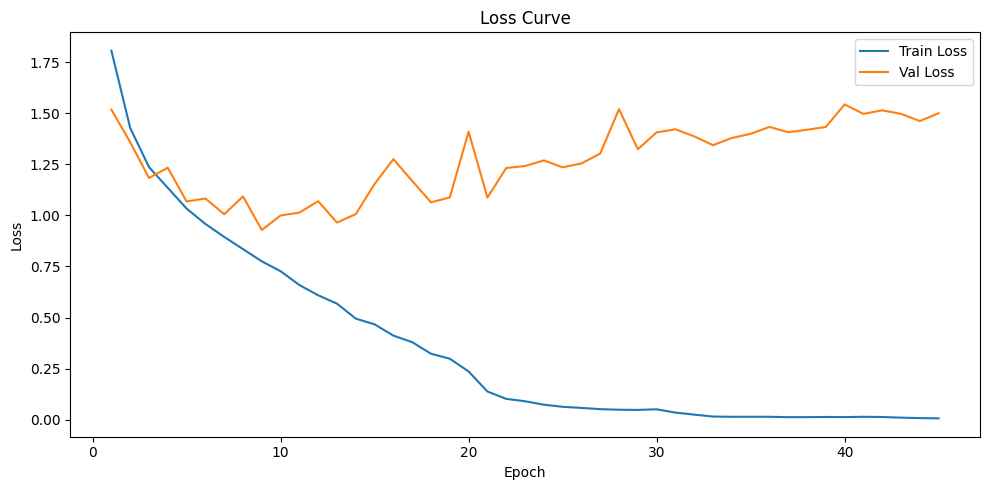

[SAVED] Accuracy curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\11class_custom_noaug/accuracy_curve.png


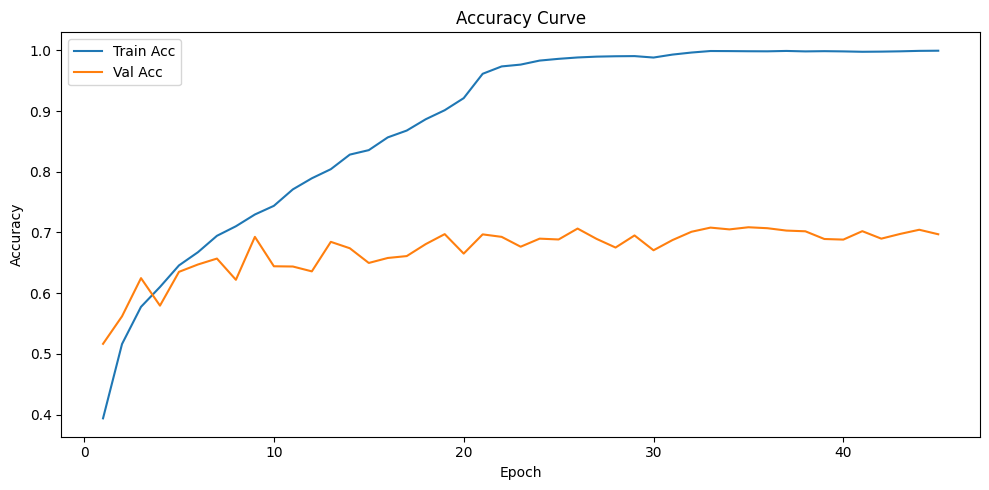

[SAVED] History JSON → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\11class_custom_noaug/history.json


In [ ]:
model_custom_11_noaug = PVClassifier(num_classes=11)
model_custom_11_noaug.loss_fn = nn.CrossEntropyLoss(weight=class_weights_11)

history_11_custom_noaug, engine_11_custom_noaug = train_and_validate(
    model=model_custom_11_noaug,
    train_loader=train11_noaug,
    val_loader=val11_noaug,
    class_names=sorted(dm11.class_names),
    save_path=SAVE_11_CUSTOM_NOAUG,
    results_dir=RESULTS_11_CUSTOM_NOAUG,
    num_epochs=200,
    lr=3e-4,
    weight_decay=1e-4,
    patience=10
)


C:\Users\Afonso Mateus\AppData\Local\Temp\ipykernel_17820\1149860589.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_


[TEST] Loss: 1.3582, Accuracy: 0.7234

Classification Report:
                precision    recall  f1-score   support

          Cell       0.67      0.65      0.66       187
    Cell-Multi       0.53      0.54      0.53       129
      Cracking       0.63      0.66      0.65        94
         Diode       0.94      0.97      0.95       150
   Diode-Multi       0.84      0.94      0.89        17
      Hot-Spot       0.79      0.60      0.68        25
Hot-Spot-Multi       0.68      0.68      0.68        25
Offline-Module       0.79      0.83      0.81        83
     Shadowing       0.73      0.80      0.76       106
       Soiling       0.29      0.10      0.15        20
    Vegetation       0.75      0.71      0.73       164

      accuracy                           0.72      1000
     macro avg       0.69      0.68      0.68      1000
  weighted avg       0.72      0.72      0.72      1000



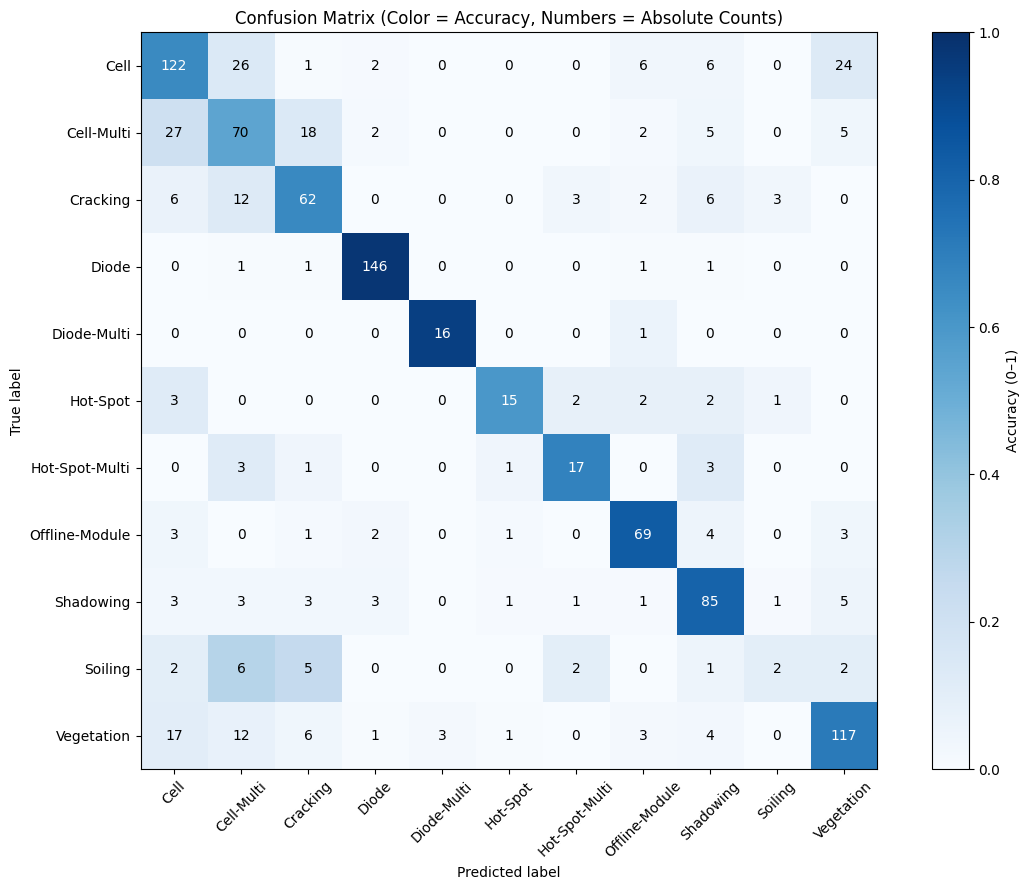

In [ ]:
results_11_custom_noaug = test_model(
    model=model_custom_11_noaug,
    weights_path=SAVE_11_CUSTOM_NOAUG,
    test_loader=test11_noaug,
    class_names=sorted(dm11.class_names)
)


In [ ]:
add_result(
    cls11_models,
    cls11_val_acc,
    cls11_test_acc,
    cls11_val_f1,
    cls11_test_f1,
    cls11_params,
    "Custom (No Aug)",
    history_11_custom_noaug,
    engine_11_custom_noaug,
    val11_noaug,
    results_11_custom_noaug
)


* **ResNet18**

c:\Users\Afonso Mateus\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Afonso Mateus\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 Starting training: ResNet18Classifier


Training Epochs:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 2/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 3/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 4/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 5/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 6/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 7/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 8/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 9/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 10/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 11/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 12/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 13/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 14/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 15/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 16/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 17/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 18/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 19/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 20/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 21/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 22/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 23/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 24/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 25/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 26/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 27/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 28/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 29/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 30/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 31/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 32/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 33/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 34/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 35/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 36/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 37/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 38/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 39/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 40/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 41/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 42/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 43/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 44/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 45/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 46/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 47/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 48/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 49/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 50/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 51/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 52/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 53/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 54/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 55/120:   0%|          | 0/227 [00:00<?, ?it/s]


Early stopping activated!
[SAVED] Loss curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\11class_resnet18/loss_curve.png


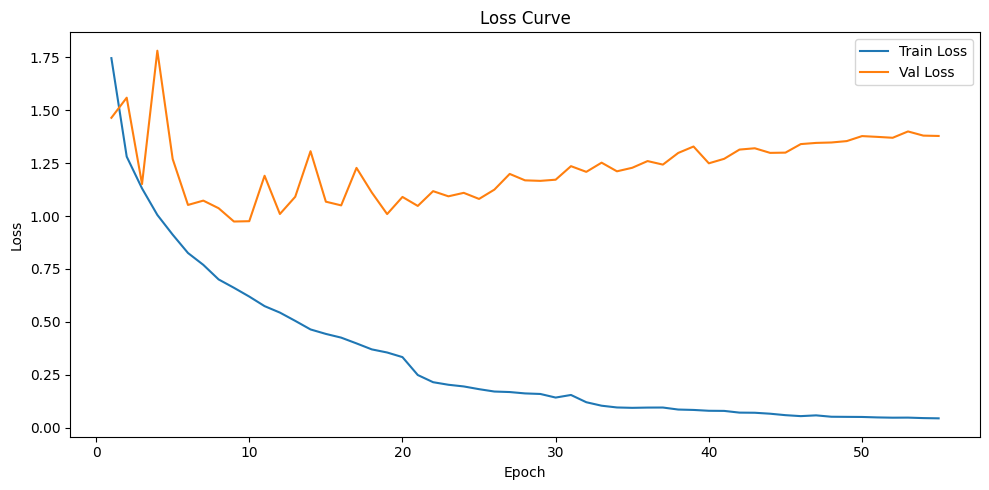

[SAVED] Accuracy curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\11class_resnet18/accuracy_curve.png


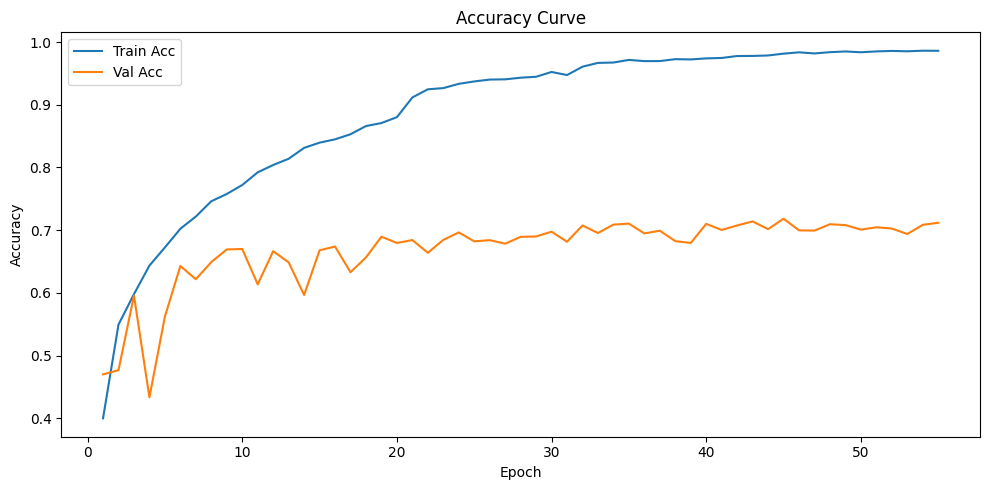

[SAVED] History JSON → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\11class_resnet18/history.json


In [ ]:
# ============================
# RESNET18 — 11 CLASSES
# ============================

model_resnet_11 = ResNet18Classifier(num_classes=11)

history_resnet_11, engine_resnet_11 = train_and_validate(
    model=model_resnet_11,
    train_loader=train11,
    val_loader=val11,
    class_names=sorted(dm11.class_names),
    save_path=SAVE_11_RESNET,
    results_dir=RESULTS_11_RESNET,
    num_epochs=120,
    lr=1e-4,
    weight_decay=1e-4,
    patience=10
)



C:\Users\Afonso Mateus\AppData\Local\Temp\ipykernel_17820\1149860589.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_


[TEST] Loss: 1.2475, Accuracy: 0.7230

Classification Report:
                precision    recall  f1-score   support

          Cell       0.69      0.62      0.65       187
    Cell-Multi       0.52      0.53      0.53       129
      Cracking       0.65      0.69      0.67        94
         Diode       0.94      0.97      0.95       150
   Diode-Multi       0.92      0.71      0.80        17
      Hot-Spot       0.68      0.68      0.68        25
Hot-Spot-Multi       0.56      0.56      0.56        25
Offline-Module       0.77      0.84      0.80        83
     Shadowing       0.77      0.84      0.80       106
       Soiling       0.36      0.25      0.29        20
    Vegetation       0.74      0.72      0.73       164

      accuracy                           0.72      1000
     macro avg       0.69      0.67      0.68      1000
  weighted avg       0.72      0.72      0.72      1000



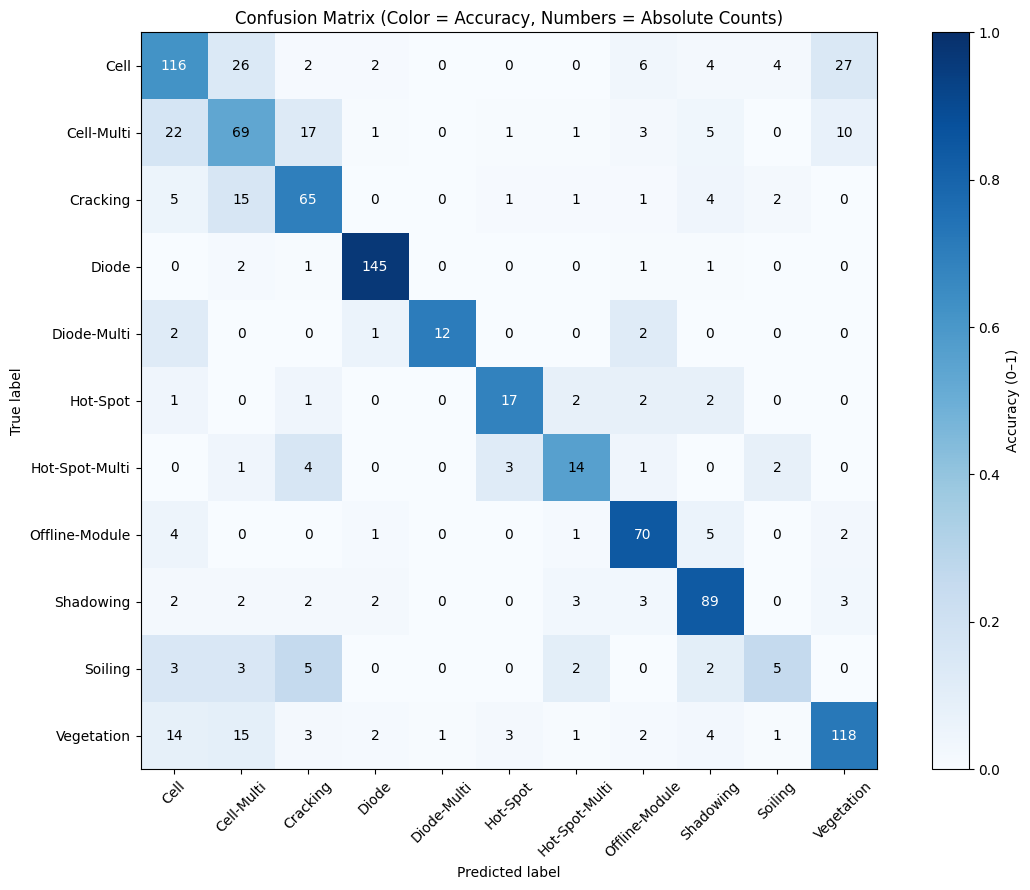

In [ ]:

results_resnet_11 = test_model(
    model=model_resnet_11,
    weights_path=SAVE_11_RESNET,
    test_loader=test11,
    class_names=sorted(dm11.class_names)
)

In [ ]:
add_result(
    cls11_models,
    cls11_val_acc,
    cls11_test_acc,
    cls11_val_f1,
    cls11_test_f1,
    cls11_params,
    "ResNet18",
    history_resnet_11,
    engine_resnet_11,
    val11,
    results_resnet_11
)


* **MobileNetV2**

c:\Users\Afonso Mateus\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Afonso Mateus\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 Starting training: MobileNetV2Classifier


Training Epochs:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 2/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 3/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 4/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 5/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 6/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 7/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 8/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 9/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 10/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 11/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 12/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 13/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 14/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 15/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 16/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 17/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 18/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 19/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 20/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 21/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 22/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 23/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 24/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 25/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 26/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 27/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 28/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 29/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 30/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 31/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 32/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 33/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 34/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 35/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 36/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 37/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 38/120:   0%|          | 0/227 [00:00<?, ?it/s]

Epoch 39/120:   0%|          | 0/227 [00:00<?, ?it/s]


Early stopping activated!
[SAVED] Loss curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\11class_mobilenetv2/loss_curve.png


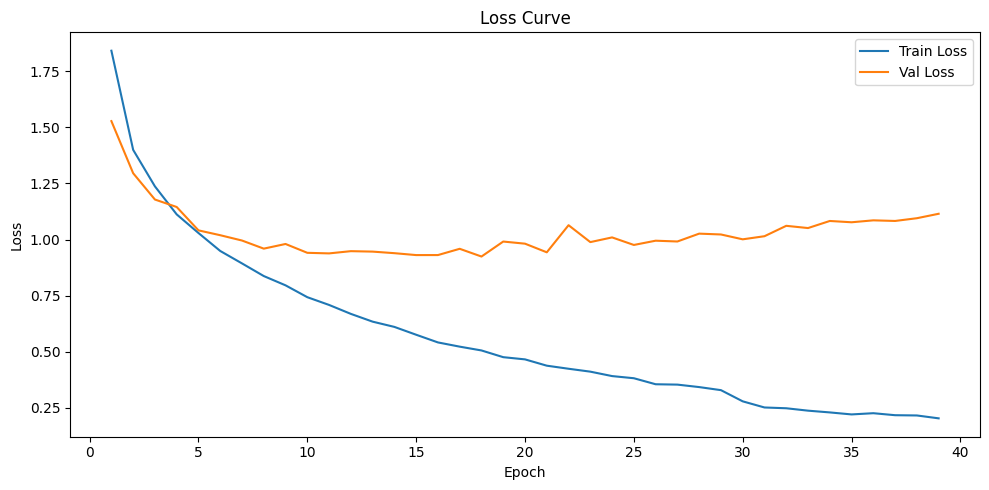

[SAVED] Accuracy curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\11class_mobilenetv2/accuracy_curve.png


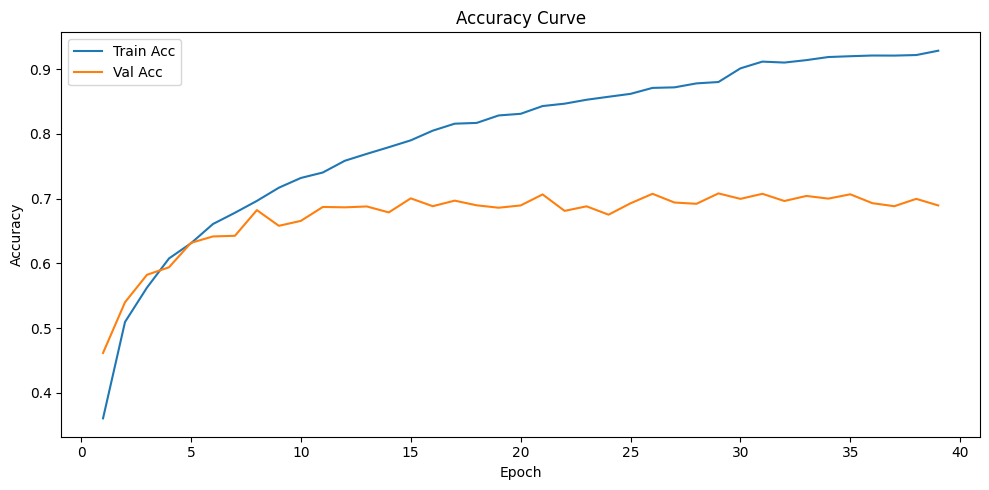

[SAVED] History JSON → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\11class_mobilenetv2/history.json


In [ ]:
# ============================
# MOBILENETV2 — 11 CLASSES
# ============================

model_mobile_11 = MobileNetV2Classifier(num_classes=11)

history_mobile_11, engine_mobile_11 = train_and_validate(
    model=model_mobile_11,
    train_loader=train11,
    val_loader=val11,
    class_names=sorted(dm11.class_names),
    save_path=SAVE_11_MOBILE,
    results_dir=RESULTS_11_MOBILE,
    num_epochs=120,
    lr=1e-4,
    weight_decay=1e-4,
    patience=10
)




C:\Users\Afonso Mateus\AppData\Local\Temp\ipykernel_17820\1149860589.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_


[TEST] Loss: 0.9874, Accuracy: 0.7213

Classification Report:
                precision    recall  f1-score   support

          Cell       0.65      0.63      0.64       187
    Cell-Multi       0.59      0.53      0.56       129
      Cracking       0.66      0.63      0.64        94
         Diode       0.90      0.98      0.94       150
   Diode-Multi       1.00      0.71      0.83        17
      Hot-Spot       0.74      0.68      0.71        25
Hot-Spot-Multi       0.59      0.68      0.63        25
Offline-Module       0.78      0.88      0.82        83
     Shadowing       0.74      0.82      0.78       106
       Soiling       0.38      0.15      0.21        20
    Vegetation       0.69      0.71      0.70       164

      accuracy                           0.72      1000
     macro avg       0.70      0.67      0.68      1000
  weighted avg       0.71      0.72      0.71      1000



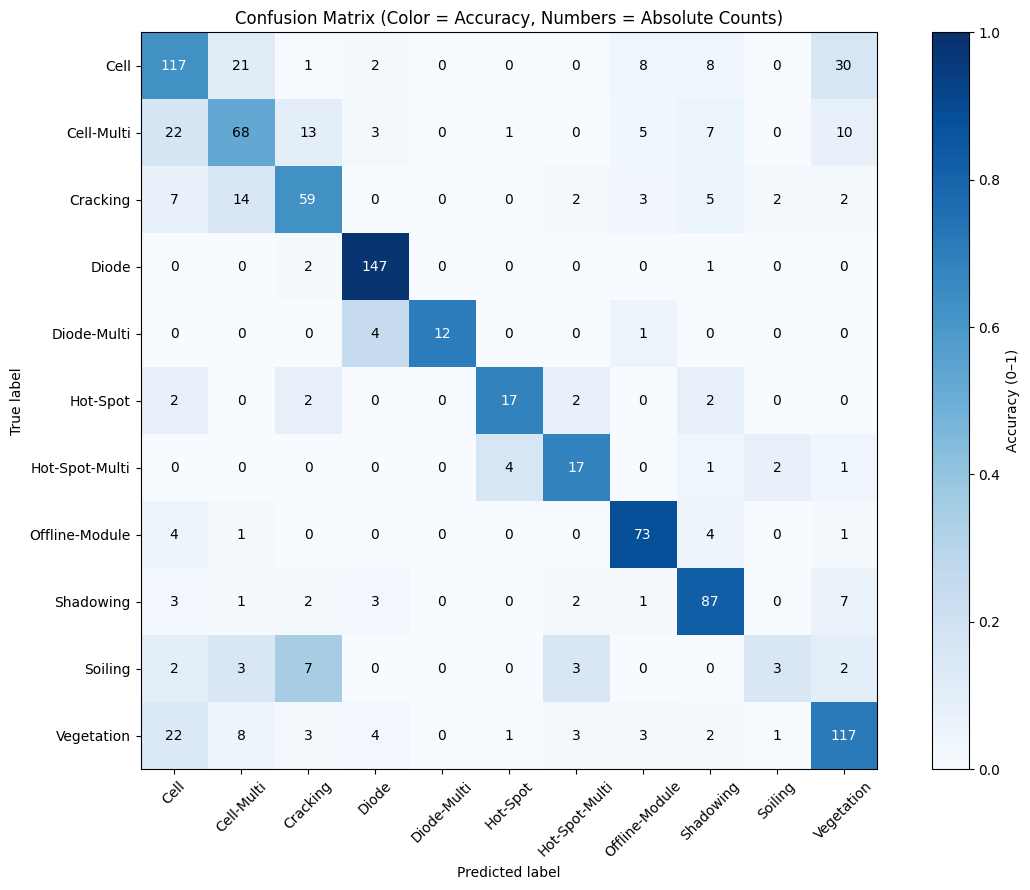

In [ ]:
results_mobile_11 = test_model(
    model=model_mobile_11,
    weights_path=SAVE_11_MOBILE,
    test_loader=test11,
    class_names=sorted(dm11.class_names)
)

In [ ]:
add_result(
    cls11_models,
    cls11_val_acc,
    cls11_test_acc,
    cls11_val_f1,
    cls11_test_f1,
    cls11_params,
    "MobileNetV2",
    history_mobile_11,
    engine_mobile_11,
    val11,
    results_mobile_11
)


###  **Results**

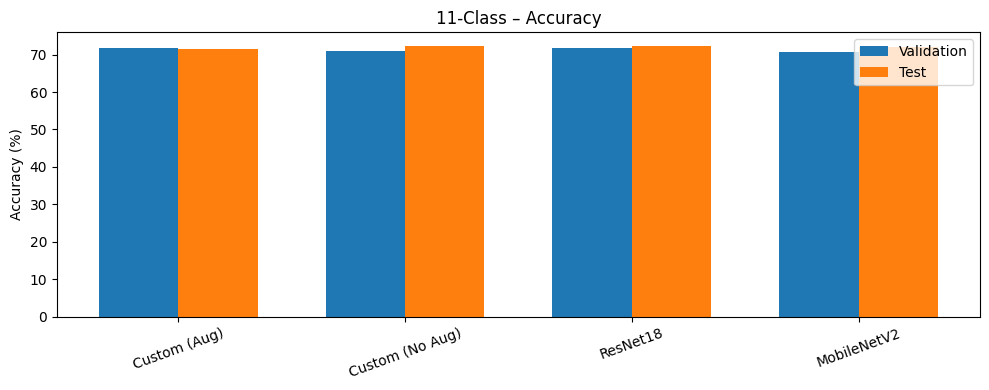

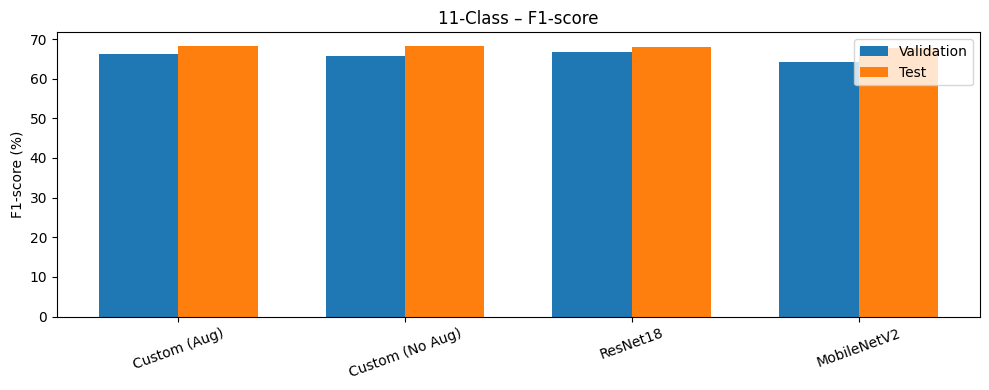

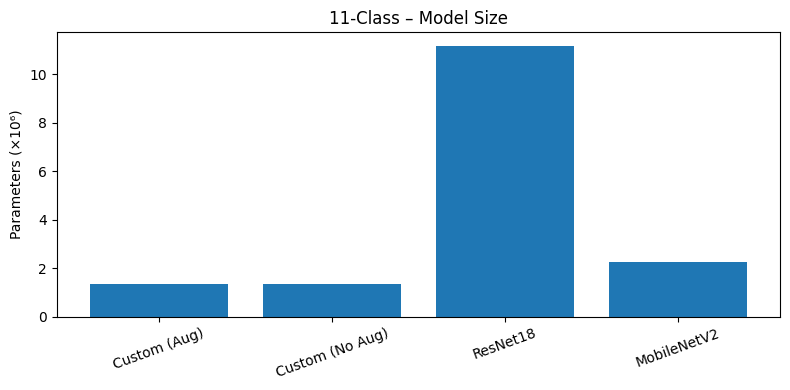

In [ ]:
x = np.arange(len(cls11_models))
w = 0.35

# ===== Accuracy =====
plt.figure(figsize=(10,4))
plt.bar(x - w/2, cls11_val_acc, w, label="Validation")
plt.bar(x + w/2, cls11_test_acc, w, label="Test")
plt.xticks(x, cls11_models, rotation=20)
plt.ylabel("Accuracy (%)")
plt.title("11-Class – Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# ===== F1-score =====
plt.figure(figsize=(10,4))
plt.bar(x - w/2, cls11_val_f1, w, label="Validation")
plt.bar(x + w/2, cls11_test_f1, w, label="Test")
plt.xticks(x, cls11_models, rotation=20)
plt.ylabel("F1-score (%)")
plt.title("11-Class – F1-score")
plt.legend()
plt.tight_layout()
plt.show()

# ===== Model Size =====
plt.figure(figsize=(8,4))
plt.bar(cls11_models, cls11_params)
plt.ylabel("Parameters (×10⁶)")
plt.title("11-Class – Model Size")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


The following Table presents the performance of the evaluated models when considering the 11-class classification problem, where only defective cells are included. Accuracy and F1-score are reported together with a qualitative comparison of the number of parameters for each architecture.

| Model               | Accuracy (%) | F1-Score (%) | # Parameters |
|---------------------|--------------|--------------|--------------|
| Custom w/ Aug       | 71.58        | 71.0         | 1,355,265    |
| Custom without Aug  | 72.34        | 72.0         | 1,355,265    |
| ResNet18            | 72.30        | 72.0         | 11,170,753   |
| MobileNetV2         | 72.13        | 72.0         | 2,224,577    |


From the results, it can be observed that, in this multi-class scenario, the Custom model without data augmentation slightly outperforms its augmented counterpart. This behavior contrasts with what was observed in the binary classification setting (normal vs. anomaly) and highlights an important difference in the nature of the task. When only defective cells are considered, the visual differences between classes tend to be more subtle, making the classification problem more challenging.

In this context, the dataset becomes more sensitive to noise, and the use of strong data augmentation techniques may distort class features that are crucial for discrimination. As a result, augmentation can act as an additional source of noise rather than a regularization mechanism, which helps explain the slight performance degradation observed for the augmented Custom model. This suggests that, for fine-grained defect classification, careful tuning of augmentation strategies is required, and that aggressive transformations may not always be beneficial (as in this case).

Furthermore, the relative performance between the different architectures (Custom, ResNet18, and MobileNetV2) remains largely consistent with the observations made previously. All models achieve very similar accuracy and F1-score values, despite their differences in complexity and number of parameters. This reinforces the conclusion that, for this task and image resolution, increasing model capacity does not lead to significant performance gains. Instead, the limiting factor appears to be the intrinsic similarity between defect classes rather than the expressive power of the model.

The confusion matrix shows that most misclassifications occur between defect classes that are visually and semantically very similar, such as Cell vs Cell-Multi and Hot-Spot vs Hot-Spot-Multi. In these cases, the distinction between classes is mainly related to how widespread the defect is or how many regions are affected, rather than to clearly distinguishable visual patterns, which naturally makes the classification task more challenging. This difficulty is further amplified when working with low-resolution images, where details are limited and subtle differences between defect types may be partially lost. As a result, most classification errors arise from strong class similarities rather than from a lack of model capacity. This helps explain why the performance differences between the tested models remain relatively small, suggesting that the main bottleneck lies in the data and in the intrinsic overlap between classes, rather than in the architecture itself. Moreover, this behavior also clarifies the reduced effectiveness of data augmentation in the multi-class setting, as additional transformations can introduce extra noise and further blur already subtle class-specific patterns, ultimately making fine-grained defect discrimination even more difficult.

The poorer performance observed for the Soiling class can largely be explained by the limited number of available samples. With such a small amount of data, the model struggles to learn a consistent and robust representation of this defect, leading to reduced generalization and increased sensitivity to noise. In addition, soiling typically produces low-contrast patterns, which are often visually similar to other defects such as shadowing or mild cell-related anomalies. This visual overlap makes the class inherently harder to distinguish, especially in low-resolution thermal images.

Overall, these results further support the efectiveness of the proposed Custom architecture while also highlighting the increased difficulty of multi-class defect classification and the role of data augmentation in such settings, wich has to be managed carefulyl.

**Conclusion**:
Defect classification is significantly more challenging due to strong class similarities, and in this setting data augmentation can act as noise, making careful augmentation design more important than model complexity.

## **12-Class Experiments**

###Models

In [ ]:
cls12_models = []
cls12_val_acc = []
cls12_test_acc = []
cls12_val_f1 = []
cls12_test_f1 = []
cls12_params = []

* **Custom**


 Starting training: PVClassifier


Training Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 2/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 3/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 4/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 5/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 6/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 7/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 8/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 9/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 10/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 11/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 12/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 13/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 14/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 15/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 16/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 17/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 18/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 19/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 20/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 21/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 22/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 23/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 24/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 25/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 26/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 27/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 28/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 29/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 30/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 31/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 32/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 33/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 34/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 35/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 36/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 37/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 38/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 39/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 40/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 41/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 42/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 43/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 44/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 45/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 46/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 47/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 48/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 49/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 50/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 51/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 52/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 53/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 54/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 55/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 56/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 57/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 58/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 59/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 60/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 61/200:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 62/200:   0%|          | 0/400 [00:00<?, ?it/s]


Early stopping activated!
[SAVED] Loss curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\12class_custom/loss_curve.png


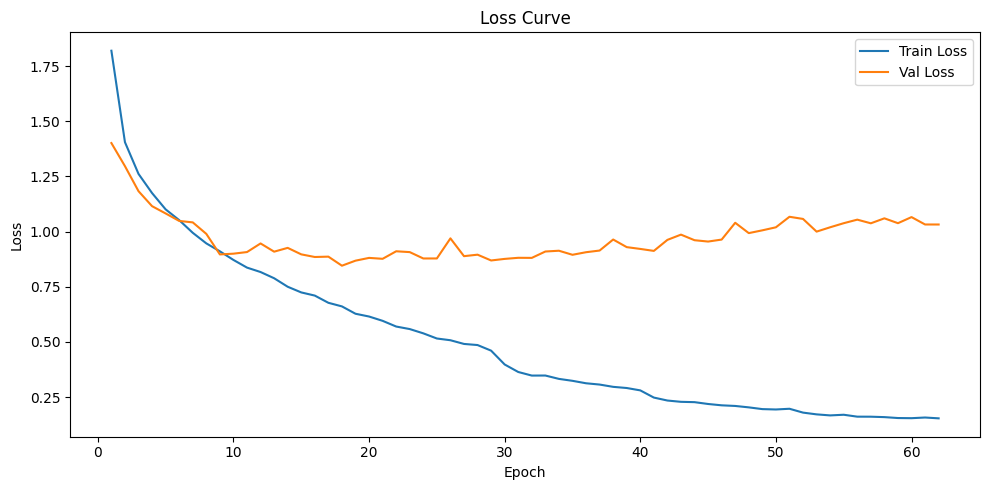

[SAVED] Accuracy curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\12class_custom/accuracy_curve.png


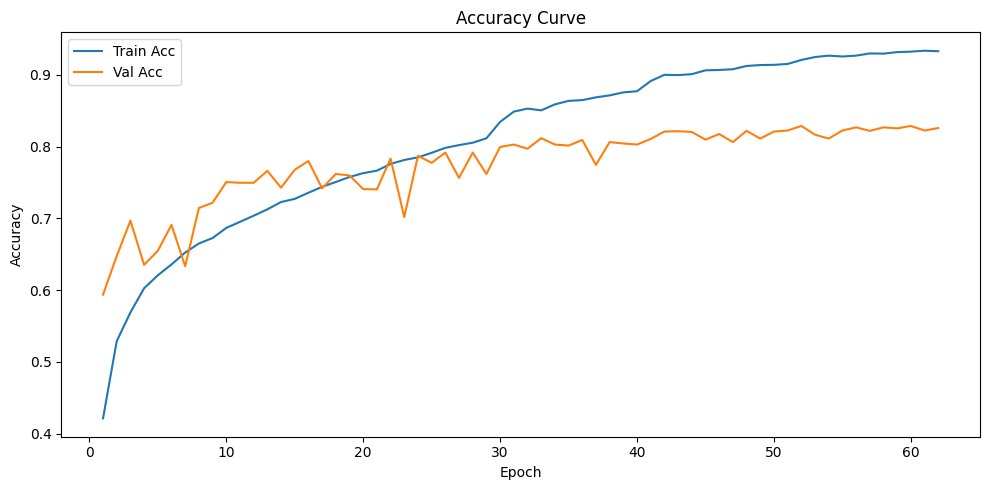

[SAVED] History JSON → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\12class_custom/history.json


In [ ]:

history_12_custom, engine_12_custom = train_and_validate(
    model=model_custom_12,
    train_loader=train12,
    val_loader=val12,
    class_names=sorted(dm12.class_names),
    save_path=SAVE_12_CUSTOM,
    results_dir=RESULTS_12_CUSTOM,
    num_epochs=200,
    lr=3e-4,
    weight_decay=1e-4,
    patience=10
)


C:\Users\Afonso Mateus\AppData\Local\Temp\ipykernel_17820\1149860589.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_


[TEST] Loss: 0.9767, Accuracy: 0.8130

Classification Report:
                precision    recall  f1-score   support

          Cell       0.60      0.68      0.64       187
    Cell-Multi       0.52      0.42      0.46       129
      Cracking       0.71      0.71      0.71        94
         Diode       0.89      0.95      0.92       150
   Diode-Multi       1.00      0.82      0.90        17
      Hot-Spot       0.67      0.72      0.69        25
Hot-Spot-Multi       0.71      0.60      0.65        25
    No-Anomaly       0.94      0.93      0.93      1000
Offline-Module       0.70      0.70      0.70        83
     Shadowing       0.74      0.76      0.75       106
       Soiling       0.67      0.30      0.41        20
    Vegetation       0.67      0.71      0.69       164

      accuracy                           0.81      2000
     macro avg       0.73      0.69      0.71      2000
  weighted avg       0.81      0.81      0.81      2000



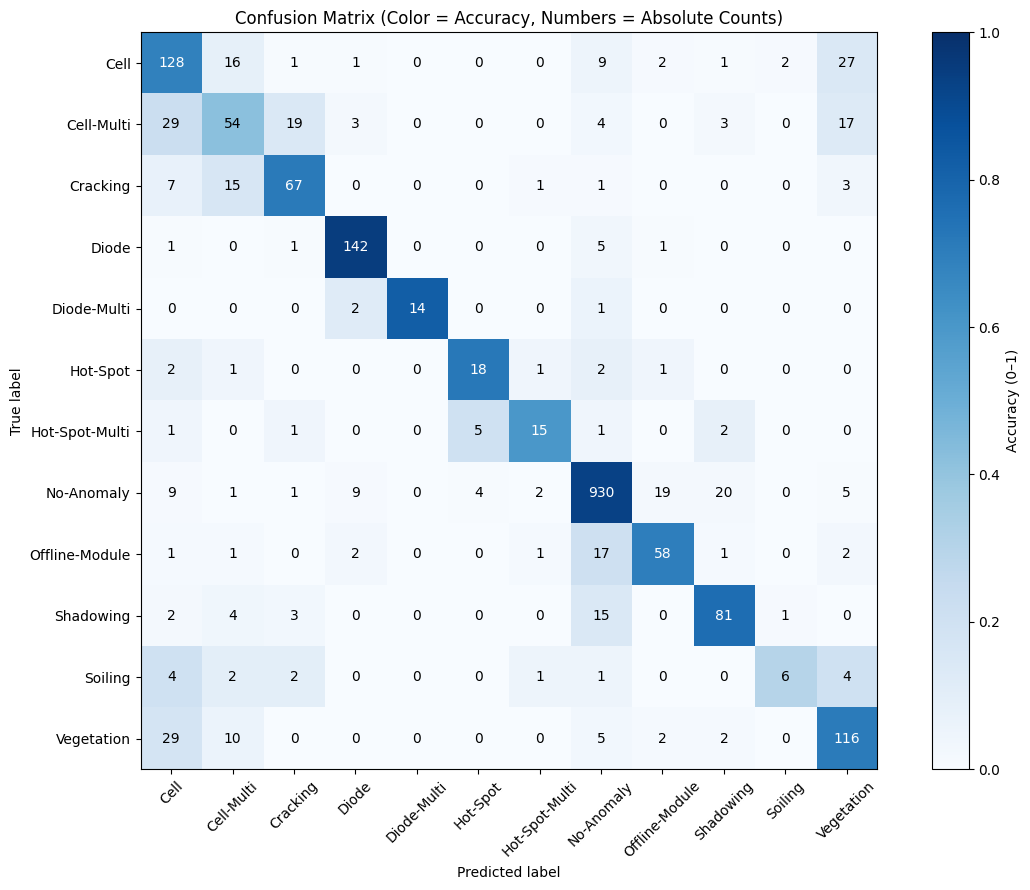

In [ ]:
results_12_custom = test_model(
    model=model_custom_12,
    weights_path=SAVE_12_CUSTOM,
    test_loader=test12,
    class_names=sorted(dm12.class_names)
)

In [ ]:
add_result(
    cls12_models,
    cls12_val_acc,
    cls12_test_acc,
    cls12_val_f1,
    cls12_test_f1,
    cls12_params,
    "Custom (Aug)",
    history_12_custom,
    engine_12_custom,
    val12,
    results_12_custom
)


* **Custom without Augmentation**


 Starting training: PVClassifier


Training Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 16/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 18/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 20/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 21/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 22/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 23/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 24/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 25/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 26/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 27/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 28/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 29/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 30/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 31/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 32/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 33/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 34/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 35/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 36/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 37/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 38/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 39/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 40/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 41/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 42/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 43/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 44/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 45/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 46/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 47/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 48/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 49/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 50/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 51/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 52/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 53/200:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 54/200:   0%|          | 0/250 [00:00<?, ?it/s]


Early stopping activated!
[SAVED] Loss curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\12class_custom_noaug/loss_curve.png


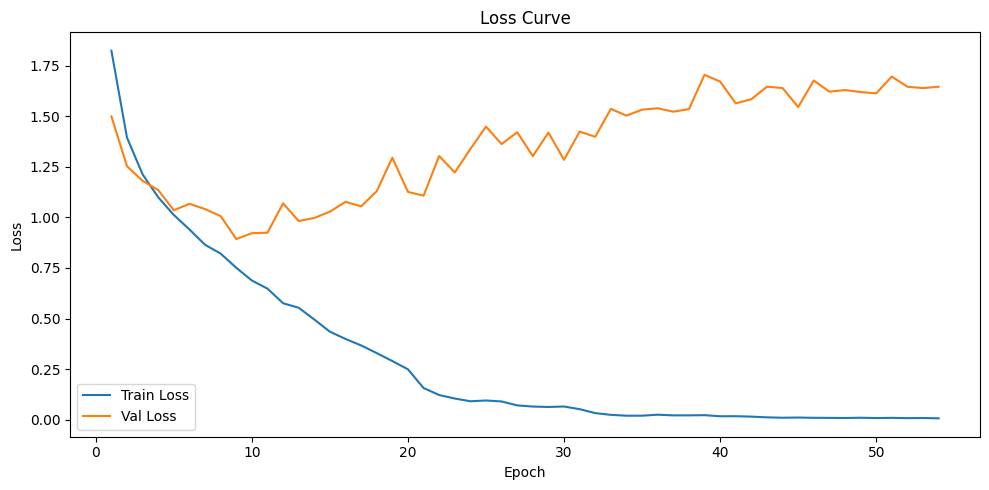

[SAVED] Accuracy curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\12class_custom_noaug/accuracy_curve.png


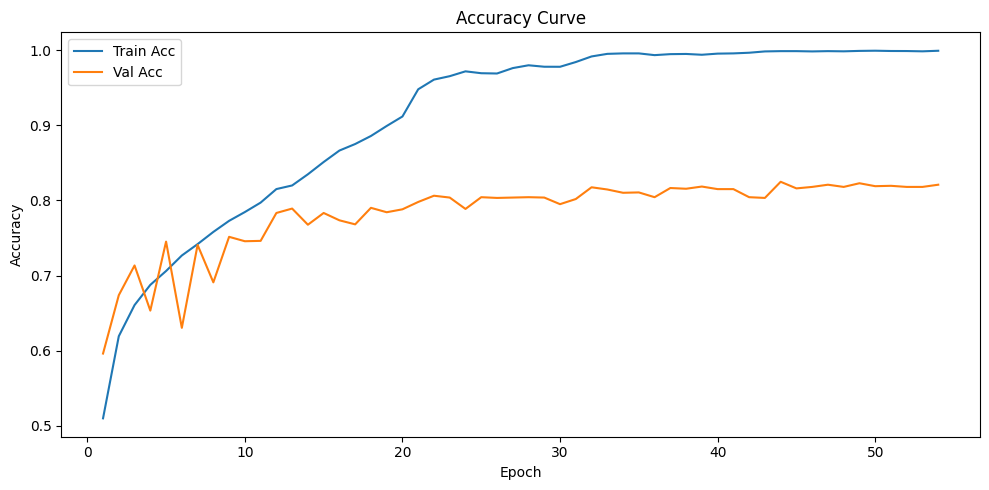

[SAVED] History JSON → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\12class_custom_noaug/history.json


In [ ]:
model_custom_12_noaug = PVClassifier(num_classes=12)
model_custom_12_noaug.loss_fn = nn.CrossEntropyLoss(weight=class_weights_12)

history_12_custom_noaug, engine_12_custom_noaug = train_and_validate(
    model=model_custom_12_noaug,
    train_loader=train12_noaug,
    val_loader=val12_noaug,
    class_names=sorted(dm12.class_names),
    save_path=SAVE_12_CUSTOM_NOAUG,
    results_dir=RESULTS_12_CUSTOM_NOAUG,
    num_epochs=200,
    lr=3e-4,
    weight_decay=1e-4,
    patience=10
)


C:\Users\Afonso Mateus\AppData\Local\Temp\ipykernel_17820\1149860589.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_


[TEST] Loss: 1.6489, Accuracy: 0.8037

Classification Report:
                precision    recall  f1-score   support

          Cell       0.62      0.61      0.62       187
    Cell-Multi       0.43      0.44      0.44       129
      Cracking       0.68      0.70      0.69        94
         Diode       0.94      0.93      0.94       150
   Diode-Multi       1.00      0.65      0.79        17
      Hot-Spot       0.62      0.52      0.57        25
Hot-Spot-Multi       0.58      0.44      0.50        25
    No-Anomaly       0.91      0.97      0.94      1000
Offline-Module       0.79      0.66      0.72        83
     Shadowing       0.80      0.70      0.74       106
       Soiling       0.25      0.15      0.19        20
    Vegetation       0.70      0.63      0.67       164

      accuracy                           0.81      2000
     macro avg       0.69      0.62      0.65      2000
  weighted avg       0.80      0.81      0.80      2000



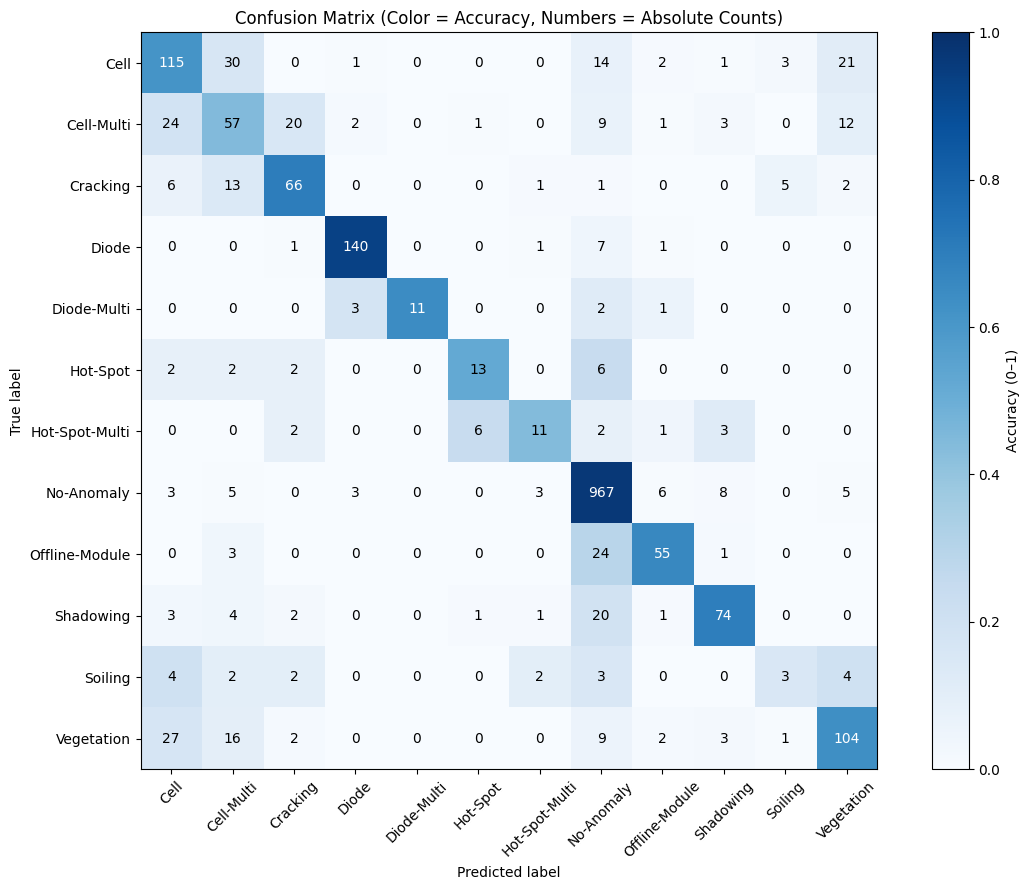

In [ ]:
results_12_custom_noaug = test_model(
    model=model_custom_12_noaug,
    weights_path=SAVE_12_CUSTOM_NOAUG,
    test_loader=test12_noaug,
    class_names=sorted(dm12.class_names)
)

In [ ]:
add_result(
    cls12_models,
    cls12_val_acc,
    cls12_test_acc,
    cls12_val_f1,
    cls12_test_f1,
    cls12_params,
    "Custom (No Aug)",
    history_12_custom_noaug,
    engine_12_custom_noaug,
    val12_noaug,
    results_12_custom_noaug
)

* **ResNet18**

c:\Users\Afonso Mateus\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Afonso Mateus\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 Starting training: ResNet18Classifier


Training Epochs:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 2/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 3/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 4/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 5/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 6/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 7/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 8/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 9/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 10/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 11/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 12/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 13/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 14/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 15/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 16/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 17/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 18/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 19/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 20/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 21/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 22/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 23/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 24/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 25/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 26/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 27/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 28/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 29/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 30/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 31/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 32/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 33/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 34/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 35/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 36/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 37/120:   0%|          | 0/400 [00:00<?, ?it/s]


Early stopping activated!
[SAVED] Loss curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\12class_resnet18/loss_curve.png


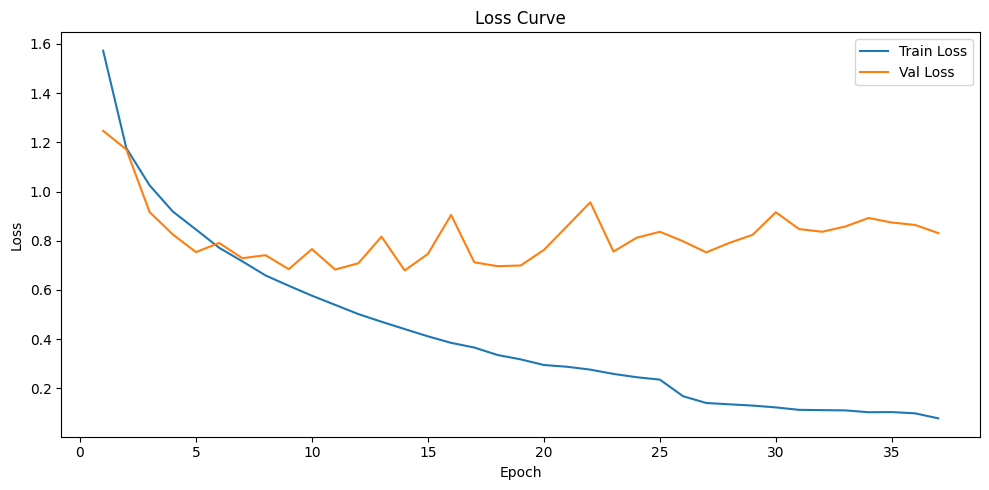

[SAVED] Accuracy curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\12class_resnet18/accuracy_curve.png


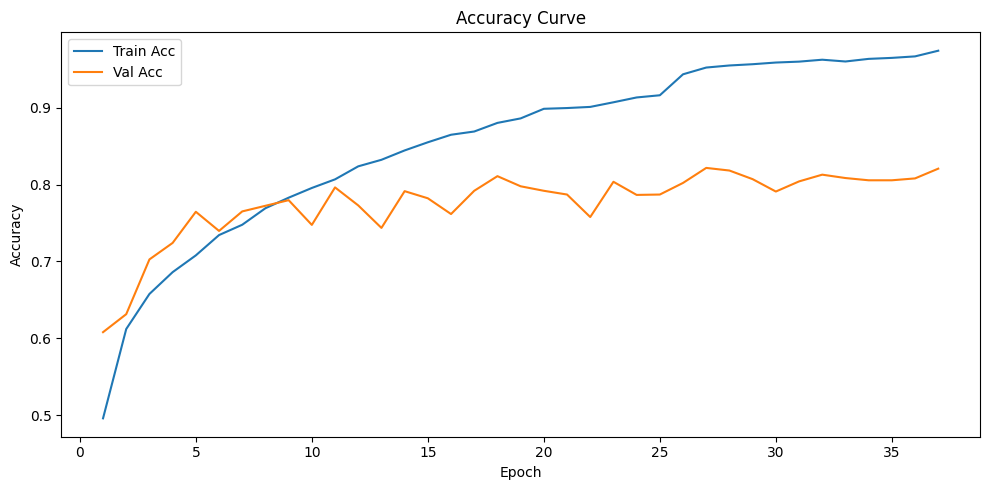

[SAVED] History JSON → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\12class_resnet18/history.json


In [ ]:
# ============================
# RESNET18 — 12 CLASSES
# ============================
model_resnet_12 = ResNet18Classifier(num_classes=12)

history_12_resnet, engine_12_resnet = train_and_validate(
    model=model_resnet_12,
    train_loader=train12,
    val_loader=val12,
    class_names=sorted(dm12.class_names),
    save_path=SAVE_12_RESNET,
    results_dir=RESULTS_12_RESNET,
    num_epochs=120,
    lr=1e-4,
    weight_decay=1e-4,
    patience=10
)


C:\Users\Afonso Mateus\AppData\Local\Temp\ipykernel_17820\1149860589.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_


[TEST] Loss: 0.7772, Accuracy: 0.8071

Classification Report:
                precision    recall  f1-score   support

          Cell       0.63      0.64      0.63       187
    Cell-Multi       0.46      0.41      0.43       129
      Cracking       0.69      0.67      0.68        94
         Diode       0.93      0.94      0.93       150
   Diode-Multi       1.00      0.82      0.90        17
      Hot-Spot       0.75      0.60      0.67        25
Hot-Spot-Multi       0.65      0.44      0.52        25
    No-Anomaly       0.92      0.96      0.94      1000
Offline-Module       0.69      0.69      0.69        83
     Shadowing       0.80      0.80      0.80       106
       Soiling       0.27      0.15      0.19        20
    Vegetation       0.63      0.63      0.63       164

      accuracy                           0.81      2000
     macro avg       0.70      0.65      0.67      2000
  weighted avg       0.80      0.81      0.81      2000



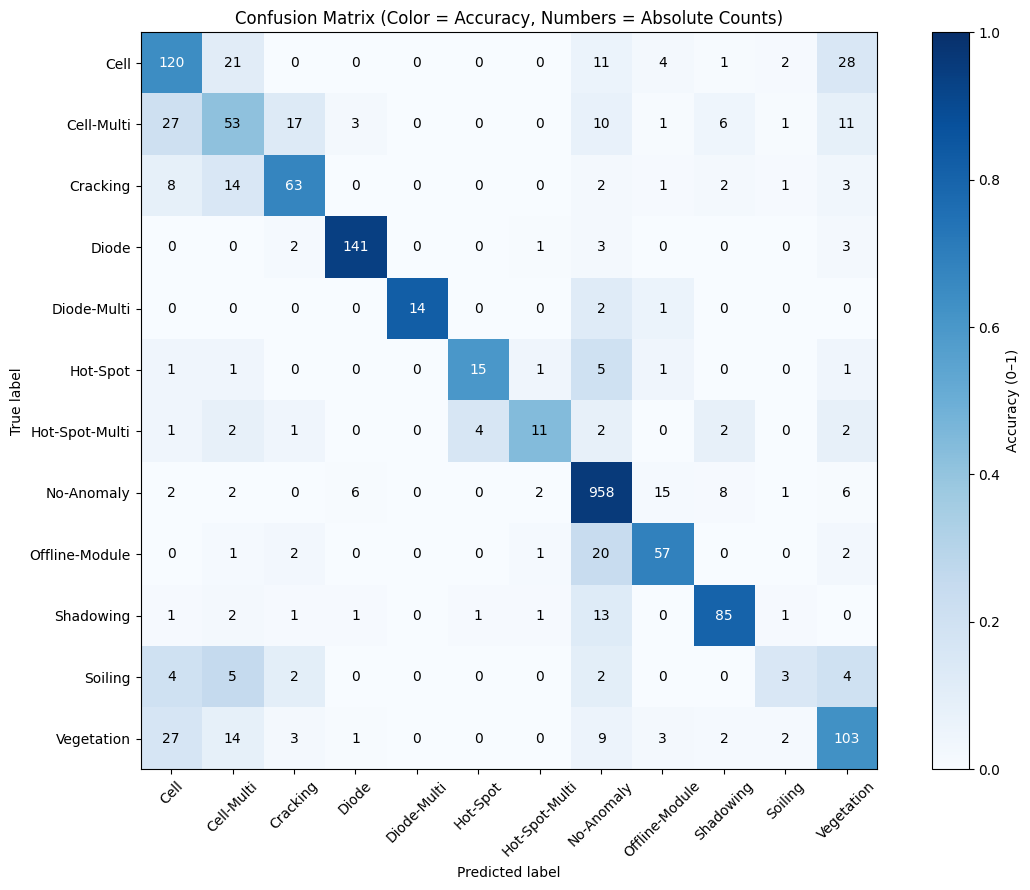

In [ ]:
results_12_resnet = test_model(
    model=model_resnet_12,
    weights_path=SAVE_12_RESNET,
    test_loader=test12,
    class_names=sorted(dm12.class_names)
)


In [ ]:
add_result(
    cls12_models,
    cls12_val_acc,
    cls12_test_acc,
    cls12_val_f1,
    cls12_test_f1,
    cls12_params,
    "ResNet18",
    history_12_resnet,
    engine_12_resnet,
    val12,
    results_12_resnet
)


* **MobileNetV2**


 Starting training: MobileNetV2Classifier


c:\Users\Afonso Mateus\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Afonso Mateus\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Epochs:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 2/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 3/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 4/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 5/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 6/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 7/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 8/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 9/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 10/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 11/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 12/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 13/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 14/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 15/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 16/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 17/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 18/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 19/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 20/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 21/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 22/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 23/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 24/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 25/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 26/120:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 27/120:   0%|          | 0/400 [00:00<?, ?it/s]


Early stopping activated!
[SAVED] Loss curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\12class_mobilenetv2/loss_curve.png


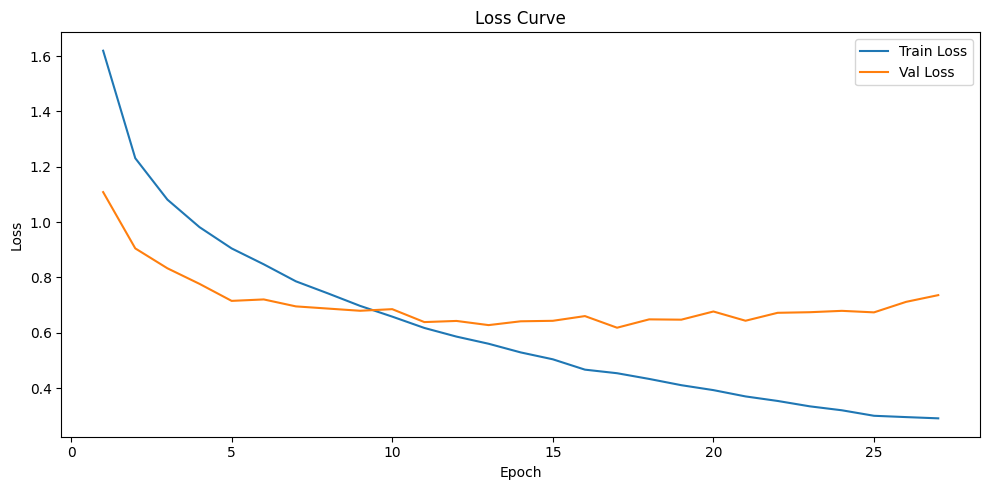

[SAVED] Accuracy curve → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\12class_mobilenetv2/accuracy_curve.png


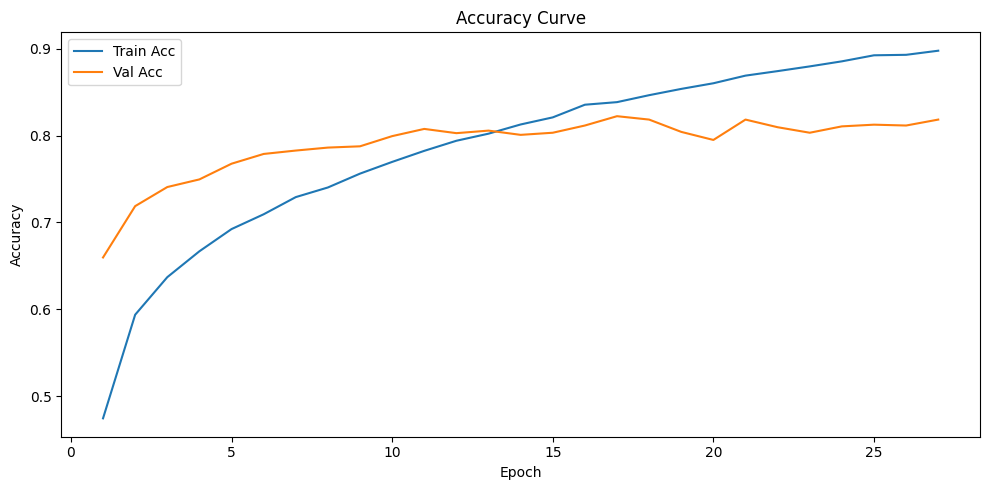

[SAVED] History JSON → c:\Users\Afonso Mateus\OneDrive\Área de Trabalho\assign2_VCOMP\PV_Project\results\12class_mobilenetv2/history.json


In [ ]:
# ============================
# MOBILENETV2 — 12 CLASSES
# ============================

model_mobile_12 = MobileNetV2Classifier(num_classes=12)

history_12_mobile, engine_12_mobile = train_and_validate(
    model=model_mobile_12,
    train_loader=train12,
    val_loader=val12,
    class_names=sorted(dm12.class_names),
    save_path=SAVE_12_MOBILE,
    results_dir=RESULTS_12_MOBILE,
    num_epochs=120,
    lr=1e-4,
    weight_decay=1e-4,
    patience=10
)



C:\Users\Afonso Mateus\AppData\Local\Temp\ipykernel_17820\1149860589.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_


[TEST] Loss: 0.6237, Accuracy: 0.7998

Classification Report:
                precision    recall  f1-score   support

          Cell       0.62      0.60      0.61       187
    Cell-Multi       0.57      0.50      0.53       129
      Cracking       0.65      0.74      0.70        94
         Diode       0.92      0.95      0.94       150
   Diode-Multi       0.93      0.76      0.84        17
      Hot-Spot       0.68      0.60      0.64        25
Hot-Spot-Multi       0.67      0.48      0.56        25
    No-Anomaly       0.90      0.95      0.92      1000
Offline-Module       0.77      0.55      0.64        83
     Shadowing       0.72      0.66      0.69       106
       Soiling       0.33      0.25      0.29        20
    Vegetation       0.64      0.60      0.62       164

      accuracy                           0.80      2000
     macro avg       0.70      0.64      0.67      2000
  weighted avg       0.79      0.80      0.80      2000



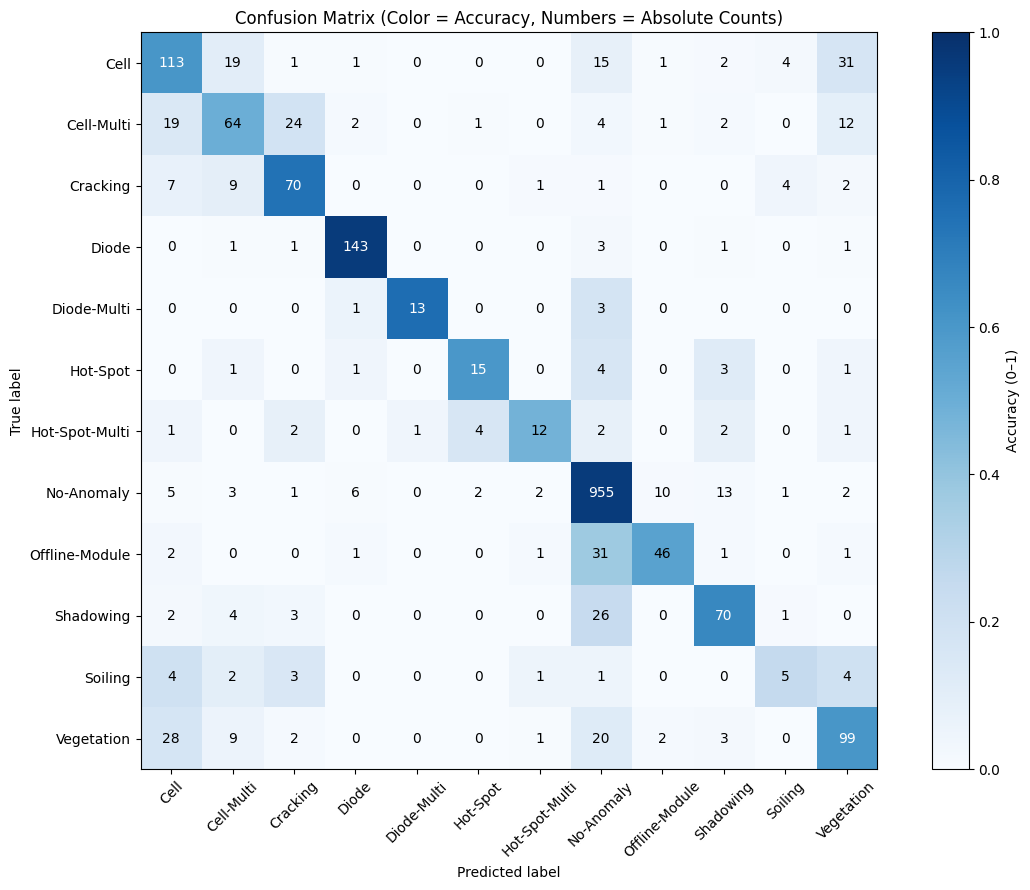

In [ ]:
results_12_mobile = test_model(
    model=model_mobile_12,
    weights_path=SAVE_12_MOBILE,
    test_loader=test12,
    class_names=sorted(dm12.class_names)
)

In [ ]:
add_result(
    cls12_models,
    cls12_val_acc,
    cls12_test_acc,
    cls12_val_f1,
    cls12_test_f1,
    cls12_params,
    "MobileNetV2",
    history_12_mobile,
    engine_12_mobile,
    val12,
    results_12_mobile
)


### **Results**

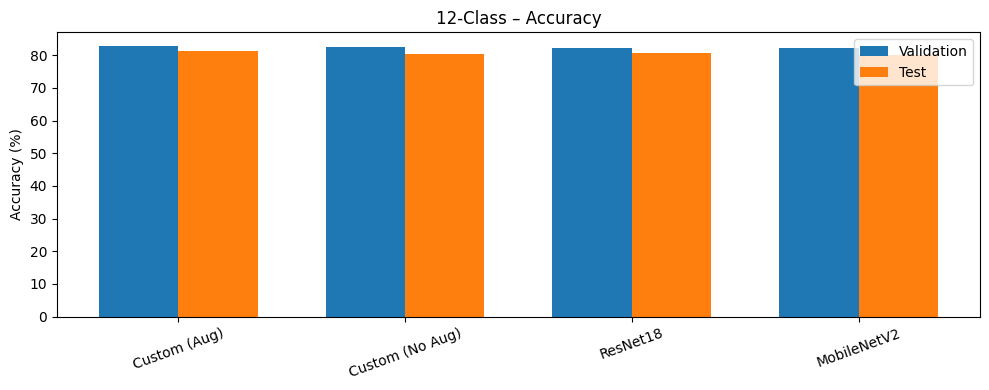

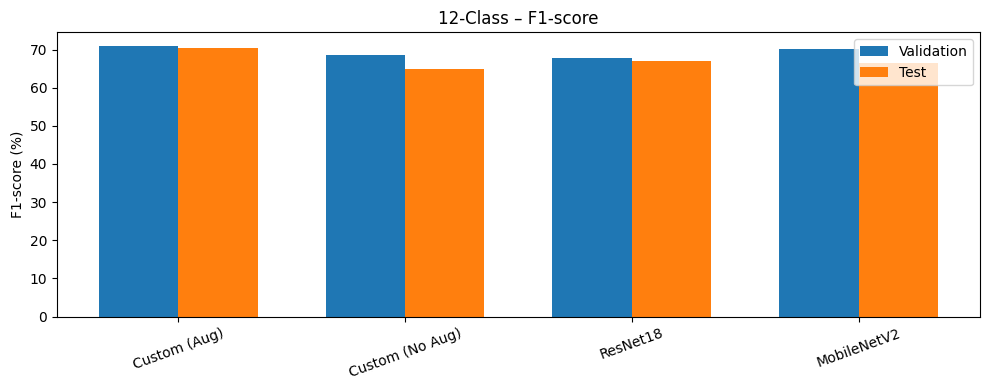

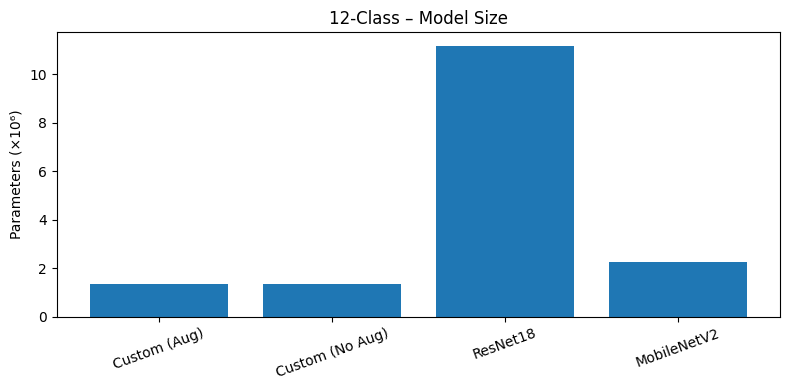

In [ ]:
x = np.arange(len(cls12_models))
w = 0.35

# ===== Accuracy =====
plt.figure(figsize=(10,4))
plt.bar(x - w/2, cls12_val_acc, w, label="Validation")
plt.bar(x + w/2, cls12_test_acc, w, label="Test")
plt.xticks(x, cls12_models, rotation=20)
plt.ylabel("Accuracy (%)")
plt.title("12-Class – Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# ===== F1-score =====
plt.figure(figsize=(10,4))
plt.bar(x - w/2, cls12_val_f1, w, label="Validation")
plt.bar(x + w/2, cls12_test_f1, w, label="Test")
plt.xticks(x, cls12_models, rotation=20)
plt.ylabel("F1-score (%)")
plt.title("12-Class – F1-score")
plt.legend()
plt.tight_layout()
plt.show()

# ===== Model Size =====
plt.figure(figsize=(8,4))
plt.bar(cls12_models, cls12_params)
plt.ylabel("Parameters (×10⁶)")
plt.title("12-Class – Model Size")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()




| Model               | Accuracy (%) | F1-Score (%) | # Parameters |
|---------------------|--------------|--------------|--------------|
| Custom w/ Aug       | 81.30        | 81.0         | Low          |
| Custom without Aug  | 80.37        | 80.0         | Low          |
| ResNet18            | 80.71        | 81.0         | High         |
| MobileNetV2         | 79.98        | 80.0         | Medium       |

These results correspond to the combined setting where both anomaly and no-anomaly classes are considered, and they show a clear improvement in overall accuracy compared to the scenario where only defect classes were used. This increase is mainly driven by the model’s strong performance in detecting the No-Anomaly class, which is also the most frequent class in the dataset. As expected, the high number of correctly classified no-anomaly samples has a significant impact on the final accuracy, leading to higher global performance values across all models. However, the confusion matrix shows that, while the model is very effective at identifying the absence of defects, it still struggles to clearly separate No-Anomaly from certain defect classes, particularly those with subtle or diffuse thermal patterns. This behavior is consistent with previous observations and highlights that the performance gain is largely influenced by class imbalance rather than by a substantial improvement in fine-grained defect discrimination.

**Conclusion**
Including the No-Anomaly class substantially increases overall accuracy, but much of this gain is driven by class imbalance, while data augmentation becomes beneficial again by improving robustness in the dominant class.

# **Discussion of Results**

The results obtained in this work are largely consistent with the findings reported by Ramadan et al. [1], particularly regarding the influence of task complexity and class granularity on photovoltaic defect classification. In both studies, simpler classification settings lead to higher performance, while fine-grained defect discrimination remains inherently challenging.

In the binary classification scenario (anomaly vs. no-anomaly), all models achieve high accuracy and F1-score values. This behavior is also observed by Ramadan et al. and can be explained by the clear thermal contrast between normal and defective modules. In this setting, data augmentation proves beneficial, improving robustness and generalization by exposing the model to a wider range of plausible variations.

The 11-class anomaly-only classification task represents the most challenging scenario. As reported in the reference article, most errors occur between visually and semantically similar defect classes, such as Cell vs Cell-Multi and Hot-Spot vs Hot-Spot-Multi, where the distinction is mainly based on defect extent rather than on distinct thermal signatures. In this context, Ramadan et al. show that transformer-based architectures can achieve improved performance by modeling global spatial relationships through self-attention mechanisms, allowing the network to better capture the overall distribution and extent of thermal anomalies across the module. However, when operating on low-resolution images, the availability of fine-grained information remains limited, and the gains obtained through increased model complexity are constrained by the intrinsic ambiguity of the data.

When extending the task to the 12-class setting by including the No-Anomaly class, overall performance improves again, in line with the observations of Ramadan et al. This improvement is mainly driven by the strong detectability and high frequency of the no-anomaly class, which has a noticeable impact on global accuracy. Confusion matrix analysis confirms that, despite higher overall performance, fine-grained defect discrimination remains difficult and that part of the gain is influenced by class imbalance.

Overall, these results support the conclusions of Ramadan et al. while highlighting complementary design trade-offs. While their transformer-based approach benefits from global context modeling and aggressive dataset balancing to better separate visually similar defect classes, the results obtained here demonstrate that a carefully designed lightweight CNN can capture the dominant thermal patterns present in low-resolution infrared images with significantly fewer parameters. This reinforces the idea that, for practical photovoltaic inspection scenarios, performance gains achieved through complex architectures must be weighed against computational cost and deployment constraints, making compact models a competitive and realistic alternative.

# **Conclusion**

This work explored the application of deep learning techniques for the automatic classification of photovoltaic module anomalies using low-resolution infrared imagery. A complete and consistent pipeline was developed, including image preprocessing, offline and online data augmentation, custom and pretrained model design, training strategies, and detailed performance evaluation. The proposed custom CNN (PVClassifier) was specifically tailored to the characteristics of thermal PV images, prioritizing compactness, stability, and generalization, while remaining suitable for edge-oriented deployment scenarios.

The experimental results consistently show that the proposed custom architecture performs on par with, and in some cases slightly better than, deeper pretrained models such as ResNet18 and MobileNetV2, despite using significantly fewer parameters. This behavior is clearly summarized in the final 2D test accuracy histogram, where all models exhibit similar trends across the binary, 11-class, and 12-class settings. The histogram highlights that performance is primarily driven by task complexity rather than by model size, confirming that for low-resolution infrared data, increasing architectural complexity does not necessarily lead to meaningful performance gains.

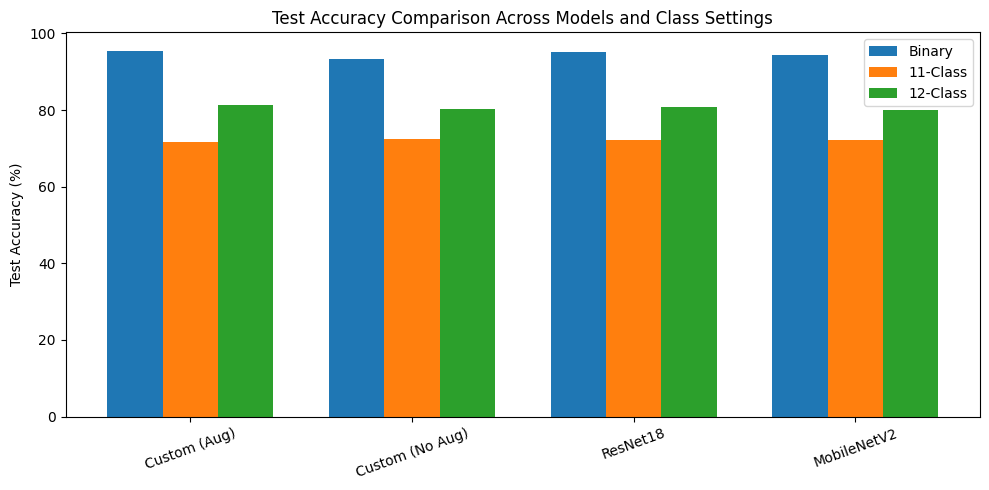

Data augmentation was shown to play a context-dependent role. In simpler classification scenarios, such as binary anomaly detection, augmentation improved robustness and reduced overfitting. However, in fine-grained multi-class defect classification, aggressive augmentation introduced additional noise and slightly degraded performance. This reinforces the idea that augmentation strategies must be carefully adapted to the nature of the task and the separability of the classes, rather than being applied uniformly across all settings.

A closer inspection of the class-wise results reveals that defects with clear and localized thermal patterns, such as Hot-Spot or Offline-Module, are detected more reliably. In contrast, classes such as Soiling, Cell, and Cell-Multi show lower recognition rates, mainly due to two factors: the limited number of available samples and strong visual and semantic similarities between classes. In these cases, the distinction often depends on subtle differences in defect extent rather than on clearly separable thermal signatures, which becomes particularly challenging under low spatial resolution. These observations indicate that the main source of error lies in the intrinsic ambiguity of the data rather than in the expressive power of the models.

Overall, this work demonstrates that effective photovoltaic fault classification can be achieved using compact CNN architectures when combined with appropriate preprocessing, balanced training strategies, and careful evaluation. The results emphasize the importance of aligning model design, data augmentation, and training choices with the characteristics of infrared imagery, while also providing practical insights for the deployment of AI-based inspection systems in real-world and resource-constrained environments.

# **References**

[1] M. Le, D. V. Le and H. H. T. Vu, “Thermal inspection of photovoltaic modules with deep convolutional neural networks on edge devices in AUV,” *Measurement*, vol. 218, p. 113135, 2023, doi: 10.1016/j.measurement.2023.113135.

[2] E. A. Ramadan, N. M. Moawad, B. A. Abouzalm, A. A. Sakr, W. F. Abouzaid and G. M. El-Banby, “An innovative transformer neural network for fault detection and classification for photovoltaic modules,” *Energy Conversion and Management*, vol. 314, p. 118718, 2024.
